

- Implementation of entropy guided unsupervised domain adaptation approach. https://www.researchgate.net/publication/345238526_Entropy_Guided_Unsupervised_Domain_Adaptation_for_Cross-Center_Hip_Cartilage_Segmentation_from_MRI

- Note, Segmenter architecture uses U-Net instead (same as https://github.com/kechua/DART20/blob/master/damri/model/unet.py).

# Imports

In [ ]:
pip install deep-pipe

In [ ]:
pip install tqdm

In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset
from dpipe.layers.resblock import ResBlock2d
from dpipe.layers.conv import PreActivation2d
import copy
import matplotlib.pyplot as plt
from statistics import mean
torch.autograd.set_detect_anomaly(True)
from tqdm import tqdm_notebook as tqdm
from statistics import mean 

import os
import random
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import string
from sklearn.preprocessing import MinMaxScaler
import torch
import nibabel as nib
from torch.utils.data import Dataset
from torch.utils.data import random_split
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

from torchvision import transforms
import torchvision
from torchvision.transforms import functional as TF

import warnings
warnings.filterwarnings('ignore')

### Set seeds 

- example from WANDB

In [ ]:
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

### Mount Drive

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
""
from google.colab import drive
drive.mount('/content/gdrive') #, force_remount = True

cuda
Mounted at /content/gdrive


## Import surface distance

- Copy DeepMinds surface distance library to your google drive and adapt folder structure accordingly.
https://github.com/deepmind/surface-distance

In [ ]:
!cp -r /content/gdrive/MyDrive/VMIA_Lab_Data/surface_distance/ .

import surface_distance.surface_distance.metrics as surf_dst

# Models

U-Net model same as https://github.com/kechua/DART20/blob/master/damri/model/unet.py

## Segmenter

In [ ]:
class UNet2D(nn.Module):
    def __init__(self, n_chans_in, n_chans_out, kernel_size=3, padding=1, pooling_size=2, n_filters_init=8,
                 dropout=False, p=0.1):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.pooling_size = pooling_size
        n = n_filters_init
        if dropout:
            dropout_layer = nn.Dropout(p)
        else:
            dropout_layer = nn.Identity()

        self.init_path = nn.Sequential(
            nn.Conv2d(n_chans_in, n, self.kernel_size, padding=self.padding, bias=False),
            nn.ReLU(),
            ResBlock2d(n, n, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n, n, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n, n, kernel_size=self.kernel_size, padding=self.padding)
        )
        self.shortcut0 = nn.Conv2d(n, n, 1)

        self.down1 = nn.Sequential(
            nn.BatchNorm2d(n),
            nn.Conv2d(n, n * 2, kernel_size=pooling_size, stride=pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer,
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding)
        )
        self.shortcut1 = nn.Conv2d(n * 2, n * 2, 1)

        self.down2 = nn.Sequential(
            nn.BatchNorm2d(n * 2),
            nn.Conv2d(n * 2, n * 4, kernel_size=pooling_size, stride=pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer,
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding)
        )
        self.shortcut2 = nn.Conv2d(n * 4, n * 4, 1)

        self.down3 = nn.Sequential(
            nn.BatchNorm2d(n * 4),
            nn.Conv2d(n * 4, n * 8, kernel_size=pooling_size, stride=pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer,
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            dropout_layer
        )

        self.up3 = nn.Sequential(
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 8, n * 8, kernel_size=self.kernel_size, padding=self.padding),
            nn.BatchNorm2d(n * 8),
            nn.ConvTranspose2d(n * 8, n * 4, kernel_size=self.pooling_size, stride=self.pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer
        )

        self.up2 = nn.Sequential(
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 4, n * 4, kernel_size=self.kernel_size, padding=self.padding),
            nn.BatchNorm2d(n * 4),
            nn.ConvTranspose2d(n * 4, n * 2, kernel_size=self.pooling_size, stride=self.pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer
        )

        self.up1 = nn.Sequential(
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            ResBlock2d(n * 2, n * 2, kernel_size=self.kernel_size, padding=self.padding),
            nn.BatchNorm2d(n * 2),
            nn.ConvTranspose2d(n * 2, n, kernel_size=self.pooling_size, stride=self.pooling_size, bias=False),
            nn.ReLU(),
            dropout_layer
        )

        self.out_path = nn.Sequential(
            ResBlock2d(n, n, kernel_size=1),
            PreActivation2d(n, n_chans_out, kernel_size=1),
            nn.BatchNorm2d(n_chans_out)
        )

    def forward(self, x , mode ='both'):
        x0 = self.init_path(x)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)

        if mode == 'emb':
          return x3

        x2_up = self.up3(x3)
        x1_up = self.up2(x2_up + self.shortcut2(x2))
        x0_up = self.up1(x1_up + self.shortcut1(x1))
        x_out = self.out_path(x0_up + self.shortcut0(x0))

        if mode == 'out':
          return F.sigmoid(x_out)

        if mode == 'both':
          return F.sigmoid(x_out), x3

## Feature Disc Model

- Adapted from : https://www.researchgate.net/publication/345238526_Entropy_Guided_Unsupervised_Domain_Adaptation_for_Cross-Center_Hip_Cartilage_Segmentation_from_MRI

In [ ]:
class Disc_Feature(nn.Module):
    def __init__(self, kernel_size=3, n_filters_init=8):
        super(Disc_Feature, self).__init__()
        n = n_filters_init

        self.conv = nn.Sequential(
            nn.Conv2d(n * 8, n * 16, stride=2, kernel_size=3),
            #nn.BatchNorm2d(n*16),
            nn.ReLU(),
            nn.Conv2d(n * 16, n * 32, stride=2, kernel_size=3),
            #nn.BatchNorm2d(n*32),
            nn.ReLU(),
            nn.Conv2d(n * 32, n * 64, stride=2, kernel_size=3),
            #nn.BatchNorm2d(n*64),
            nn.ReLU(),
            #nn.Dropout(0.25)
        )

        self.flat_map_dim = 512*3*3
        
        self.fc = nn.Sequential(
        nn.Linear(self.flat_map_dim, 64),
        #nn.BatchNorm1d(64),
        nn.ReLU(),
        #nn.Dropout(0.5),
        nn.Linear(64, 1)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        feature_map = self.conv(x)

        batch_size = feature_map.shape[0]

        out = self.fc(feature_map.view(batch_size,-1))

        return self.sigmoid(out)

x = torch.rand(8, 64, 36, 36)
model = Disc_Feature()
print(model(x))
print(model(x).shape)

tensor([[0.4778],
        [0.4778],
        [0.4778],
        [0.4786],
        [0.4768],
        [0.4766],
        [0.4773],
        [0.4773]], grad_fn=<SigmoidBackward0>)
torch.Size([8, 1])


## Entropy Disc Model

- Adapted from : https://www.researchgate.net/publication/345238526_Entropy_Guided_Unsupervised_Domain_Adaptation_for_Cross-Center_Hip_Cartilage_Segmentation_from_MRI

In [ ]:
class Disc_Entropy(nn.Module):
  def __init__(self, kernel_size = 3, n_filters_init = 1):
    super(Disc_Entropy, self).__init__()
    n = n_filters_init

    self.conv = nn.Sequential(
        nn.Conv2d( 1 , 32, stride=2, kernel_size=3),
        #nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d( 32, 64 , stride=2, kernel_size=3),
        #nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d( 64, 128, stride=2, kernel_size=3),
        #nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 256, stride=2, kernel_size=3),
        #nn.BatchNorm2d( 256),
        nn.ReLU(),
        nn.Conv2d(256, 512, stride=2, kernel_size=3),
        #nn.BatchNorm2d( 512),
        nn.ReLU(),
        #nn.Dropout(0.25)
    )

    self.flat_map_dim = 512*8*8 

    self.fc = nn.Sequential(
        nn.Linear(self.flat_map_dim, 512),
        #nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 64),
        #nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 1)
        #nn.Dropout(0.5),    
    )

    self.sigmoid = nn.Sigmoid()
   

  def forward(self, x):

    x1 = self.conv(x) # (B, 512, 8, 8)

    batch_size = x1.shape[0]
    
    x2 = self.fc( x1.view(batch_size,-1) )

    return self.sigmoid(x2)

x = torch.rand(8, 1, 288, 288)
model = Disc_Entropy()
print(model(x))
print(model(x).shape)

tensor([[0.5107],
        [0.5105],
        [0.5105],
        [0.5106],
        [0.5106],
        [0.5106],
        [0.5107],
        [0.5106]], grad_fn=<SigmoidBackward0>)
torch.Size([8, 1])


# Dataset

- change domain and type based on requirements
- After downloading the CC359 dataset (https://sites.google.com/view/calgary-campinas-dataset/home) you can upload the scans to your google drive with the folder structure mentioned below:

- The folder structure used for running this notebook is: 
  - base_path = '/content/gdrive/MyDrive/VMIA_Lab_Data/data/'
  - original_path = base_path + 'Original/Original/'
  - mask_path = base_path + 'Silver-standard-machine-learning/Silver-standard/'

- Adapt your folder structure accordingly. Alternatively make changes in the Dataset class of the code.

In [ ]:
src_domain = 'ge'
src_domain_type = '3'
trg_domain = 'philips'
trg_domain_type = '3'

## Preprocess scans

In [ ]:
def process_image(img, max_pad = 288, mask_flag = False):
     
    img = np.float32(img)

    '''
    CLIP
    '''
    if mask_flag != True:
      img = np.clip(img, *np.percentile( img, [1, 99]))

    '''
    MIN-MAX SCALE THE IMAGE
    '''
    assert (len(img.shape) == 3)
    
    if img.min() != 0:
      print("Exception: min is not 0 but: ", img.min())
      img -= np.min(img)
    
    img = img/img.max()
    
  
    '''
    PAD IMAGE TO MAX SIZE
    '''
    
    pad_x = int((max_pad - img.shape[1])/2)
    pad_y = int((max_pad - img.shape[2])/2)

    return np.pad(img, pad_width = ((0, 0), (pad_x, pad_x), (pad_y, pad_y)), mode =  'constant', constant_values = 0)



## Train dataset class


In [ ]:
class Scan_Data(Dataset):
  def __init__(self, src_domain = 'ge', src_scan_type = '3', trg_domain = 'philips', trg_scan_type = '3', mode = 'train'):

    '''
    # Set Paths
    '''
    self.base_path = '/content/gdrive/MyDrive/VMIA_Lab_Data/data/'
    self.original_path = self.base_path + 'Original/Original/'
    self.mask_path = self.base_path + 'Silver-standard-machine-learning/Silver-standard/'


    '''
    # Extract src and target splits
    '''
    with open(self.base_path + 'data_split_dict.pkl', 'rb') as handle:
      data_split = pickle.load(handle)
    self.src_image_list = data_split[src_domain + '_' + src_scan_type + '_' + mode]

    if trg_domain == 'ge' and trg_scan_type == '15':
      self.trg_image_list = data_split[trg_domain + '_' + trg_scan_type + '_' + mode][:31]
    else:
      self.trg_image_list = data_split[trg_domain + '_' + trg_scan_type + '_' + mode]
    
    '''
    # Load src and trg images
    '''
    self.src_images = torch.from_numpy(np.concatenate(
      [process_image(nib.load(self.original_path + img_file).get_fdata(), mask_flag = False) for img_file in self.src_image_list]))
    self.trg_images = torch.from_numpy(np.concatenate(
      [process_image(nib.load(self.original_path + img_file).get_fdata(), mask_flag = False) for img_file in self.trg_image_list]))
    
    self.src_size = len(self.src_images)
    self.trg_size = len(self.trg_images)
    
    '''
    # Concatenate images
    '''
    self.images = torch.cat([ self.src_images, self.trg_images ])
    self.labels = torch.cat([ torch.ones(self.src_size), torch.zeros(self.trg_size) ])

    '''
    # Shuffle after concatenating
    '''
    indexes = list(range(len(self.images)))
    random.shuffle(indexes)

    del self.src_images, self.trg_images #DELETE TO SAVE RAM

    self.images = self.images[indexes]
    self.labels = self.labels[indexes]

    '''
    # Load masks, concatenate and shuffle
    '''
    self.src_masks =  torch.from_numpy(np.concatenate(
      [process_image(nib.load(self.mask_path + img_file[:-7] + '_ss.nii.gz').get_fdata(), mask_flag = True) for img_file in self.src_image_list]))
    self.trg_masks =  torch.from_numpy(np.concatenate(
      [process_image(nib.load(self.mask_path + img_file[:-7] + '_ss.nii.gz').get_fdata(), mask_flag = True) for img_file in self.trg_image_list]))

    self.masks = torch.cat([self.src_masks, self.trg_masks])
    del self.src_masks, self.trg_masks
    self.masks = self.masks[indexes]

    print(self.images.shape, self.src_size, self.trg_size, self.src_size + self.trg_size)
    print(self.masks.shape)
    print(self.labels.shape)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):

    original_batch = self.images[idx]
    mask_batch = self.masks[idx]

    labels = self.labels[idx]

    return original_batch, mask_batch, labels 

In [ ]:
batch_size = 64

train_data = Scan_Data( src_domain, src_domain_type, trg_domain, trg_domain_type, 'train')

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True, num_workers = 0)

torch.Size([15828, 288, 288]) 8088 7740 15828
torch.Size([15828, 288, 288])
torch.Size([15828])


## Val dataset class

In [ ]:
class Scan_Val(Dataset):
  def __init__(self, domain_type, mode, domain = 'ge', scan_type = '3'):

    # BASE PATHS #
    self.base_path = '/content/gdrive/MyDrive/VMIA_Lab_Data/data/'
    self.original_path = self.base_path + 'Original/Original/'
    self.mask_path = self.base_path + 'Silver-standard-machine-learning/Silver-standard/'
  
    # OBTAIN IMAGES FROM SPLIT #
    with open(self.base_path + 'data_split_dict.pkl', 'rb') as handle:
      data_split = pickle.load(handle)
      
    self.image_list = data_split[ domain + '_' + scan_type + '_' + mode]
    
    self.images = torch.from_numpy(np.concatenate(
      [process_image(nib.load(self.original_path + img_file).get_fdata(), mask_flag = False) for img_file in self.image_list]))
    
    self.masks = torch.from_numpy(np.concatenate(
      [process_image(nib.load(self.mask_path + img_file[:-7] + '_ss.nii.gz').get_fdata(), mask_flag = True) for img_file in self.image_list]))

  
    if domain_type == 'src':
      self.labels = torch.ones(len(self.images))
    elif domain_type == 'trg':
      self.labels = torch.zeros(len(self.images))
      
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):

    original_batch = self.images[idx]
    mask_batch = self.masks[idx]
    labels = self.labels[idx]

    return original_batch, mask_batch, labels 

In [ ]:
batch_size = 16
src_val_data = Scan_Val('src','val', src_domain, src_domain_type)
trg_val_data = Scan_Val('trg','val', trg_domain, trg_domain_type)

src_val_loader = torch.utils.data.DataLoader(dataset = src_val_data, batch_size = batch_size, shuffle = False, num_workers = 0)
trg_val_loader = torch.utils.data.DataLoader(dataset = trg_val_data, batch_size = batch_size, shuffle = False, num_workers = 0)

print(len(src_val_data), len(trg_val_data))
print(src_val_data.images.shape, trg_val_data.images.shape)
print(src_val_data.labels.shape, trg_val_data.labels.shape)

2552 1980
torch.Size([2552, 288, 288]) torch.Size([1980, 288, 288])
torch.Size([2552]) torch.Size([1980])


# Loss

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth= 1e-7):
      
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()  
                                 
        dice_loss = 1 - (2.*intersection + smooth)/( (inputs**2).sum() + (targets**2).sum() + smooth)  

        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE #BCE, dice_loss

In [ ]:
@torch.no_grad()
def Dice_Score(inputs, targets, smooth=0.0000001):
    # flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()

    dice_score = (2. * intersection + smooth) / ( (inputs**2).sum() + (targets**2).sum() + smooth)

    return dice_score.detach().item()  

In [ ]:
@torch.no_grad()
def Volumetric_Dice_Score(path, filename, segmenter):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # READ IMG AND GET PREDS
   
    segmenter.eval()

    img = process_image(nib.load(path + 'Original/Original/' + filename).get_fdata(), mask_flag = False)
    
    batch_size = 1
    out,_ = segmenter(torch.from_numpy( img[0:0 + batch_size,:,:]).unsqueeze(dim = 1).float().to(device))
    start_idx = batch_size

    for i in tqdm(range( int(img.shape[0]/batch_size) - 1)):
      out1,_ = segmenter(torch.from_numpy( img[start_idx: start_idx+ batch_size,:,:]).unsqueeze(dim = 1).float().to(device))
      out = torch.cat([out, out1], dim = 0)
      start_idx += batch_size
    
    pred = torch.where(out > 0.5, 1, 0)

    # READ MASK 
    mask_filename = filename.split(".nii")[0] + "_ss.nii.gz"
    mask = process_image(nib.load(path + 'Silver-standard-machine-learning/Silver-standard/' + mask_filename).get_fdata(), mask_flag = True)

    mask_bool = mask.astype(bool)
    pred_bool = pred.squeeze().detach().to('cpu').numpy().astype(bool)

    assert img.shape == mask.shape == mask_bool.shape == pred_bool.shape
    print("shapes: ",img.shape)

    # GET SCORE
    score = surf_dst.compute_dice_coefficient( mask_bool, pred_bool)

    sds = surf_dst.compute_surface_distances( mask_bool, pred_bool, [1,1,1])

    sdat = surf_dst.compute_surface_dice_at_tolerance(sds, 1)    
    hd = surf_dst.compute_robust_hausdorff(sds, 95)

    print(filename,"Surface Dice:",score,"| SD at tol:", sdat,"| HD:", hd)

    return score, sdat, hd

@torch.no_grad()         
def Eval_Vol_Dice(domain_type, domain, scan_type, mode, segmenter, val_stats, curr_epoch):

    dice_scores = []
    sdat_scores = []
    hd_scores = []

    base_path = '/content/gdrive/MyDrive/VMIA_Lab_Data/data/'

    with open(base_path + 'data_split_dict.pkl', 'rb') as handle:
      volume_path_dict = pickle.load(handle)

    file_list = volume_path_dict[str(domain) + '_' + scan_type + '_' + str(mode)]

    for filename in tqdm(file_list):
      
      score, sdat, hd = Volumetric_Dice_Score(base_path, filename, segmenter)
      dice_scores.append( score )
      sdat_scores.append( sdat )
      hd_scores.append( hd )



    val_stats[domain_type + '_val_vol_dice'][curr_epoch] = dice_scores
    val_stats[domain_type + '_val_vol_sdat'][curr_epoch] = sdat_scores
    val_stats[domain_type + '_val_vol_hd'][curr_epoch] = hd_scores

    val_vol_dice = mean(dice_scores)
    val_vol_sdat = mean(sdat_scores)
    val_vol_hd = mean(hd_scores)
    
    print()
    print(domain,'vol metrics for epoch',curr_epoch)
    print('AVG VOLUMETRIC DICE :',val_vol_dice,"| SD AT TOL:", val_vol_sdat,"| HD:", val_vol_hd,'#########')


    return val_stats

In [ ]:
def plotting( original, mask, pred, ent_map):
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
  fig.set_size_inches(6, 8, forward=True)
  fig.set_dpi(120)
  #fig.tight_layout()
  ax1.imshow(original[0][0], cmap = 'gray')
  ax2.imshow(mask[0][0], cmap = 'gray')
  ax3.imshow(pred[0][0], cmap = 'gray')
  ax4.imshow(ent_map[0][0], cmap = 'jet')
  ax1.set_title('original')
  ax2.set_title('mask')
  ax3.set_title('pred')
  ax4.set_title('ent_map')
  
  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  ax4.axis('off')
  
  #plt.savefig(path + str(current_epoch) + '_' + str(batch_idx))
  plt.pause(0.00001)

# Train function

In [ ]:
def train(curr_epoch, optimizers, models, lambdas, train_loader, train_stats, device):
  '''
  UNPACK EVERYTHING
  '''

  seg_opt, feat_disc_opt, ent_disc_opt = optimizers
  lambda1, lambda2, lambda3 = lambdas
  segmenter, feature_discriminator, entropy_discriminator = models  

  segmenter.train(); segmenter.zero_grad();
  feature_discriminator.train(); feature_discriminator.zero_grad();
  entropy_discriminator.train(); entropy_discriminator.zero_grad();

  '''
  INITIALIZE LOSSES AND STATS
  '''
  dice_bce_loss = DiceBCELoss().to(device) #Only Segmenter
  fd_bce_loss = torch.nn.BCELoss().to(device) #Disc,Ent and Adverse
  ed_bce_loss = torch.nn.BCELoss().to(device)
  fa_bce_loss = torch.nn.BCELoss().to(device)
  ea_bce_loss = torch.nn.BCELoss().to(device)

  comb_hist = []; seg_hist = []; 
  feat_disc_hist = []; feat_adv_hist = [];
  ent_disc_hist = []; ent_adv_hist = [];
  src_dice = []; trg_dice = [];
  ent_direct_hist = [];

  feat_adv_correct = 0; ent_adv_correct = 0; 
  feat_adv_total = 0; ent_adv_total = 0;
  
  feat_disc_correct = 0; ent_disc_correct = 0; 
  feat_disc_total = 0; ent_disc_total = 0; 

  feat_disc_src_correct = 0; ent_disc_src_correct = 0; 
  feat_disc_src_total = 0;  ent_disc_src_total = 0;
  feat_disc_trg_correct = 0;  ent_disc_trg_correct = 0; 
  feat_disc_trg_total = 0;  ent_disc_trg_total = 0;

  entropy_src = []; entropy_trg = [];

  '''
  ITERATE
  '''

  for batch_idx, data in enumerate(train_loader):

      segmenter.zero_grad(); feature_discriminator.zero_grad(); entropy_discriminator.zero_grad();
      seg_opt.zero_grad(); feat_disc_opt.zero_grad(); ent_disc_opt.zero_grad();

      '''
      UNPACK DATA
      '''
      original = torch.unsqueeze(data[0].float(), axis = 1).to(device) # 4D: B,1,H,W
      mask = torch.unsqueeze(data[1].float(), axis = 1).to(device) # 4D: B,1,H,W
      label = data[2].float().to(device) # 1D

      src_idx = (label == 1)
      src_original = original[src_idx]
      src_mask = mask[src_idx]
      src_label = label[src_idx]

      trg_idx = (label == 0)
      trg_original = original[trg_idx]
      trg_mask = mask[trg_idx]
      trg_label = label[trg_idx]

      assert (src_label == 1).all()
      assert (trg_label == 0).all()


      '''
      #############
      # SEGMENTER #
      #############
      '''

      '''
      IF SRC IMGS IN BATCH -> SEG LOSS 
      '''
    
      if len(src_label) > 0:
        
        src_seg_out, src_seg_emb = segmenter(src_original, mode = 'both')
        seg_loss = dice_bce_loss(src_seg_out, src_mask)

        src_prob_map = torch.where( src_seg_out > 0.5, src_seg_out, 1- src_seg_out)
        src_ent_map = -src_prob_map * (torch.log2( src_prob_map + 1e-30))


      '''
      IF TRG IMGS IN BATCH -> ENTROPY DISC ADV. LOSS 
      '''
      if len(trg_label) > 0:
        trg_seg_out, trg_seg_emb = segmenter(trg_original, mode = 'both')
        trg_adv_label = torch.logical_not(trg_label).float()
        
        trg_prob_map = torch.where( trg_seg_out > 0.5, trg_seg_out, 1- trg_seg_out)
        trg_ent_map = -trg_prob_map * (torch.log2( trg_prob_map + 1e-30))

        feat_disc_out = feature_discriminator(trg_seg_emb)
        feat_disc_adv_loss = fa_bce_loss(feat_disc_out.squeeze(), trg_adv_label.squeeze())

        ent_disc_out = entropy_discriminator(trg_ent_map)
        ent_disc_adv_loss = ea_bce_loss( ent_disc_out.squeeze(), trg_adv_label.squeeze())

      
      '''
      (FEATURE DISC ADV. LOSS) & (DIRECT ENTROPY LOSS)
      ''' 

      if (label == 1).all():
        
        direct_entropy = torch.mean(src_ent_map)


      elif (label == 0).all():

        direct_entropy = torch.mean(trg_ent_map)
      
      else:

        direct_entropy  = torch.mean(src_ent_map) + torch.mean(trg_ent_map)
        
      
      if (label == 1).all():

        combined_loss = seg_loss + lambda3 * direct_entropy 
        
    
      elif (label == 0).all():
        combined_loss = lambda1 * feat_disc_adv_loss + lambda2 * ent_disc_adv_loss + lambda3 * direct_entropy

     
      else:
        combined_loss = seg_loss + lambda1*feat_disc_adv_loss + lambda2*ent_disc_adv_loss + lambda3 * direct_entropy
        
      combined_loss.backward()
      seg_opt.step()

      '''
      #### SEG METRICS ####
      '''
      

      if len(trg_label) > 0:

        feat_adv_preds = torch.where( feat_disc_out > 0.5, 1, 0)
        feat_adv_correct += ( trg_adv_label.squeeze() == feat_adv_preds.squeeze() ).sum().item()
        feat_adv_total += len(trg_adv_label)

        ent_adv_preds = torch.where( ent_disc_out > 0.5, 1, 0)
       
        ent_adv_correct += ( trg_adv_label == ent_adv_preds.squeeze()).sum().item()
    
        ent_adv_total += len(trg_adv_label)

     

      if len(src_label) > 0:
        src_output = torch.where(src_seg_out > 0.5, 1, 0)
        src_dice.append( Dice_Score(src_output.squeeze(), src_mask.squeeze()) )

    
      if len(trg_label)>0:
        with torch.no_grad():
          trg_output = torch.where(trg_seg_out > 0.5, 1, 0)
          trg_dice.append( Dice_Score(trg_output.squeeze(), trg_mask.squeeze()) )
          seg_opt.zero_grad(); 


      segmenter.zero_grad(); feature_discriminator.zero_grad(); entropy_discriminator.zero_grad();
      seg_opt.zero_grad(); feat_disc_opt.zero_grad(); ent_disc_opt.zero_grad();   


      '''
      # COMBINE SRC AND TARGETS & RESHUFFLE FOR DISC. OPERATIONS
      '''
      
      img_new = torch.cat([src_original, trg_original])
      mask_new = torch.cat([src_mask, trg_mask])
      label_new = torch.cat([ torch.ones(len(src_label)), torch.zeros(len(trg_label)) ]).to(device)
        
      seg_out = torch.cat([src_seg_out, trg_seg_out])
      seg_emb = torch.cat([src_seg_emb, trg_seg_emb])
      ent_map = torch.cat([src_ent_map, trg_ent_map])
      
      assert len(label_new)==len(label)
      indexes = list(range(len(label)))
      random.shuffle(indexes)

      img_new = img_new[indexes]
      mask_new = mask_new[indexes]
      label_new = label_new[indexes]

      seg_out = seg_out[indexes]
      seg_emb = seg_emb[indexes]
      ent_map = ent_map[indexes]
      
      src_idx_new = (label_new == 1)
      trg_idx_new = (label_new == 0)

      src_label_new = label_new[src_idx_new]
      trg_label_new = label_new[trg_idx_new]

      assert (src_label_new == 1).all()
      assert (trg_label_new == 0).all()


      '''
      #################################
      ##### FEATURE DISCRIMINATOR #####
      '''
      
      feat_disc_out = feature_discriminator(seg_emb.detach())
      feat_disc_loss = fd_bce_loss( feat_disc_out.squeeze(), label_new.squeeze())

      feat_disc_loss.backward()
      feat_disc_opt.step()

      '''
      ### FEAT DISC STATS ###
      '''
      feat_disc_preds = torch.where(feat_disc_out.squeeze() > 0.5, 1, 0)   
      feat_disc_correct += (label_new.squeeze() == feat_disc_preds.squeeze()).sum().item()
      feat_disc_total += len(label_new.squeeze())
      
      # EXTRACT SRC AND TRG ACC.
      assert len(src_label) == len(src_label_new)
      assert len(trg_label) == len(trg_label_new)

      # EXTRACT SRC AND TRG ACC.
      if len(src_label_new) > 0:
        feat_disc_src_correct += (feat_disc_preds[src_idx_new].squeeze() == src_label_new.squeeze()).sum().item()
        feat_disc_src_total += len(src_label_new)
      if len(trg_label_new) > 0: 
        feat_disc_trg_correct += (feat_disc_preds[trg_idx_new].squeeze() == trg_label_new.squeeze()).sum().item()
        feat_disc_trg_total += len(trg_label_new)
 
      segmenter.zero_grad(); feature_discriminator.zero_grad(); entropy_discriminator.zero_grad();
      seg_opt.zero_grad(); feat_disc_opt.zero_grad(); ent_disc_opt.zero_grad();  


      '''
      #################################
      ##### ENTROPY DISCRIMINATOR #####
      '''
      ent_disc_out = entropy_discriminator(ent_map.detach())
      ent_disc_loss = ed_bce_loss( ent_disc_out.squeeze(), label_new.squeeze()) 

      ent_disc_loss.backward()
      ent_disc_opt.step()

      '''
      ### ENT DISC STATS ###
      '''
      ent_disc_preds = torch.where(ent_disc_out.squeeze() > 0.5, 1, 0)  

      ent_disc_correct += (label_new.squeeze() == ent_disc_preds.squeeze()).sum().item()

      ent_disc_total += len(label_new.squeeze())

      
      if len(src_label_new) > 0:
        ent_disc_src_correct += (ent_disc_preds[src_idx_new].squeeze() == src_label_new.squeeze()).sum().item()
        ent_disc_src_total += len(src_label_new)
      if len(trg_label_new) > 0: 
        ent_disc_trg_correct += (ent_disc_preds[trg_idx_new].squeeze() == trg_label_new.squeeze()).sum().item()
        ent_disc_trg_total += len(trg_label_new)

      '''
      ###### PRINT #######
      '''
      if (batch_idx % 50 == 0):
          if (len(src_original)>0):
            plotting(src_original.detach().cpu().numpy(), src_mask.detach().cpu().numpy(), src_seg_out.detach().cpu().numpy(), src_ent_map.detach().cpu().numpy())
            
          if (len(trg_original)>0):
            plotting(trg_original.detach().cpu().numpy(), trg_mask.detach().cpu().numpy(), trg_seg_out.detach().cpu().numpy(), trg_ent_map.detach().cpu().numpy())
          
      if (batch_idx % 30 == 0):

          print(curr_epoch,",",batch_idx,"/",len(train_loader),
                  " || Combined Seg Loss:",np.round(combined_loss.item(),2),
                  "(", np.round(seg_loss.item(),2),"+ L1*", np.round(feat_disc_adv_loss.item(),2),"+ L2*", np.round(ent_disc_adv_loss.item(),2),"+ L3*", np.round(direct_entropy.item(),2),")",  #"+ L3*", np.round(direct_entropy.item(),2),")",        
                  " || Feat Disc Loss:",np.round(feat_disc_loss.item(),2), " || Ent Disc Loss:",np.round(ent_disc_loss.item(),2))


      if len(src_label) > 0:
        seg_hist.append(seg_loss.item())
      if len(trg_label) > 0:
        feat_adv_hist.append(feat_disc_adv_loss.item())
        ent_adv_hist.append(ent_disc_adv_loss.item())
        
      
      comb_hist.append(combined_loss.item())
      feat_disc_hist.append(feat_disc_loss.item())    
      ent_disc_hist.append(ent_disc_loss.item())
      ent_direct_hist.append(direct_entropy.item())
     
  ent_disc_acc = (ent_disc_correct/ent_disc_total)
  ent_disc_src_acc = (ent_disc_src_correct/ent_disc_src_total)
  ent_disc_trg_acc = (ent_disc_trg_correct/ent_disc_trg_total)

  feat_disc_acc = (feat_disc_correct/feat_disc_total)
  feat_disc_src_acc = (feat_disc_src_correct/feat_disc_src_total)
  feat_disc_trg_acc = (feat_disc_trg_correct/feat_disc_trg_total)

  ent_adv_acc = (ent_adv_correct/ent_adv_total)
  feat_adv_acc = (feat_adv_correct/feat_adv_total)

  print("Entropy Discrim. Acc: ", ent_disc_acc, "( Src:", ent_disc_src_acc , ", Trg:", ent_disc_trg_acc, ")")
  print("Entropy Adversarial Acc:", ent_adv_acc)

  print("Feature Discrim. Acc: ", feat_disc_acc, "( Src:", feat_disc_src_acc , ", Trg:", feat_disc_trg_acc, ")")
  print( "Feature Adversarial Acc:", feat_adv_acc)
  
  avg_src_dice = np.mean(np.array(src_dice))
  avg_trg_dice = np.mean(np.array(trg_dice))
  print("AVG TRAIN SRC DICE:", avg_src_dice)
  print("AVG TRAIN TRG DICE:", avg_trg_dice) 


  train_stats['combined_loss'][curr_epoch] = comb_hist 
  train_stats['seg_loss'][curr_epoch] = seg_hist

  train_stats['feat_disc_loss'][curr_epoch] = feat_disc_hist
  train_stats['ent_disc_loss'][curr_epoch] = ent_disc_hist
  
  train_stats['ent_direct_loss'][curr_epoch] = ent_direct_hist
  train_stats['ent_direct_src'][curr_epoch] = entropy_src
  train_stats['ent_direct_trg'][curr_epoch] = entropy_trg
 
  train_stats['feat_adv_loss'][curr_epoch] = feat_adv_hist
  train_stats['ent_adv_loss'][curr_epoch] = ent_adv_hist

  train_stats['feat_disc_acc'][curr_epoch] = feat_disc_acc
  train_stats['feat_disc_src_acc'][curr_epoch] = feat_disc_src_acc
  train_stats['feat_disc_trg_acc'][curr_epoch] = feat_disc_trg_acc
    
  train_stats['ent_disc_acc'][curr_epoch] = ent_disc_acc
  train_stats['ent_disc_src_acc'][curr_epoch] = ent_disc_src_acc
  train_stats['ent_disc_trg_acc'][curr_epoch] = ent_disc_trg_acc

  train_stats['feat_adv_acc'][curr_epoch] = feat_adv_acc
  train_stats['ent_adv_acc'][curr_epoch] = ent_adv_acc    

  '''
  PACK AND RETURN
  '''

  optimizers = (seg_opt, feat_disc_opt, ent_disc_opt)
  models = (segmenter, feature_discriminator, entropy_discriminator)

  return train_stats, models, optimizers



# Validation

In [ ]:
@torch.no_grad()
def val(curr_epoch, models, lambdas, val_loader, val_stats, device, domain):


  '''
  UNPACK EVERYTHING
  '''
  
  lambda1, lambda2, lambda3 = lambdas #lambda3 = lambdas
  segmenter, feature_discriminator, entropy_discriminator = models  

  segmenter.eval(); 
  feature_discriminator.eval(); 
  entropy_discriminator.eval(); 
  
  '''
  INITIALIZE LOSSES AND STATS
  '''
  dice_bce_loss = DiceBCELoss().to(device)
  fd_bce_loss = torch.nn.BCELoss().to(device)
  ed_bce_loss = torch.nn.BCELoss().to(device)  
  fa_bce_loss = torch.nn.BCELoss().to(device)
  ea_bce_loss = torch.nn.BCELoss().to(device)


  comb_hist = []; seg_hist = []; src_dice = []; trg_dice = [];
  feat_disc_hist = []; feat_adv_hist = [];
  ent_disc_hist = []; ent_adv_hist = [];
  ent_direct_hist = [];

  feat_adv_correct = 0; ent_adv_correct = 0; 
  feat_adv_total = 0; ent_adv_total = 0;
  
  feat_disc_correct = 0; ent_disc_correct = 0; 
  feat_disc_total = 0; ent_disc_total = 0; 


  '''
  ITERATE
  '''

  for batch_idx, data in enumerate(val_loader):

      '''
      UNPACK DATA
      '''
      original = torch.unsqueeze(data[0].float(), axis = 1).to(device) # 4D: B,1,H,W
      mask = torch.unsqueeze(data[1].float(), axis = 1).to(device) # 4D: B,1,H,W
      label = data[2].float().to(device) # 1D

      '''
      ##### SEGMENTER #####
      '''
      seg_out, seg_emb = segmenter(original, mode = 'both')

      ent_out = torch.where( seg_out > 0.5, seg_out , 1- seg_out)
      ent_map = -ent_out*(torch.log2(ent_out+ 1e-30))

       #### SEPARATE SOURCE AND TARGET DATA ####
      src_idx = (label == 1)
      src_original = original[src_idx]
      src_mask = mask[src_idx]
      src_label = label[src_idx]

      trg_idx = (label == 0)
      trg_original = original[trg_idx]
      trg_mask = mask[trg_idx]
      trg_label = label[trg_idx]

      if len(src_label) > 0:
        src_seg_out = seg_out[src_idx]
        seg_loss = dice_bce_loss(src_seg_out, src_mask)
      else:
        seg_loss = torch.Tensor([0]).to(device)


      
      '''
      ADVERSARIAL FEAT. & ENT. DISC
      '''
      if len(trg_label) > 0:
        
        # OBTAIN LABELS AND INPUTS(ONLY TARGET PROB MAPS)
        trg_adv_label = torch.logical_not(trg_label).float()


        trg_seg_emb = seg_emb[trg_idx]
        feat_disc_out = feature_discriminator(trg_seg_emb)  
        feat_disc_adv_loss = fa_bce_loss( feat_disc_out.squeeze(), trg_adv_label.squeeze())

        trg_seg_out = seg_out[trg_idx]
      
        # CONVERT PROBABILITY MAP TO ENTROPY MAP   
        trg_ent_out = torch.where( trg_seg_out > 0.5, trg_seg_out , 1- trg_seg_out)
        trg_ent_map = -trg_ent_out*(torch.log2(trg_ent_out+ 1e-30))

        # PASS TO DISC       
        ent_disc_out = entropy_discriminator(trg_ent_map)
        ent_disc_adv_loss = ea_bce_loss( ent_disc_out.squeeze(), trg_adv_label.squeeze())

       
          
      else:
        feat_disc_adv_loss = torch.Tensor([0]).to(device)
        ent_disc_adv_loss = torch.Tensor([0]).to(device)
        
      
      ent_direct_loss = torch.mean(ent_map) 
        

      combined_loss = seg_loss + lambda1*feat_disc_adv_loss + lambda2*ent_disc_adv_loss + lambda3*(ent_direct_loss)

      '''
      CALC SEG METRICS
      '''
    
      

      if len(trg_label) > 0:

          feat_adv_preds = torch.where( feat_disc_out > 0.5, 1, 0)
          feat_adv_correct += ( trg_adv_label.squeeze() == feat_adv_preds.squeeze() ).sum().item()
          feat_adv_total += len( trg_adv_label)

          ent_adv_preds = torch.where( ent_disc_out > 0.5, 1, 0)
  
          ent_adv_correct += ( trg_adv_label == ent_adv_preds.squeeze()).sum().item()
       
          ent_adv_total += len(trg_adv_label)

      if len(src_label) > 0:
        src_output = torch.where(src_seg_out > 0.5, 1, 0)
        src_dice.append( Dice_Score(src_output.squeeze(), src_mask.squeeze()) )

      '''
      ##### FEATURE DISCRIMINATOR #####
      '''
      
      emb_for_disc = torch.clone(seg_emb.detach())
      feat_disc_out = feature_discriminator(emb_for_disc)

      feat_disc_loss = fd_bce_loss( feat_disc_out.squeeze(), label.squeeze())

      '''
      ### FEAT DISC STATS ###
      '''
      feat_disc_preds = torch.where(feat_disc_out.squeeze() > 0.5, 1, 0)   
      feat_disc_correct += (label.squeeze() == feat_disc_preds.squeeze()).sum().item()
      feat_disc_total += len(label.squeeze())

      '''
      ##### ENTROPY DISCRIMINATOR #####
      '''
      
      prob_map = torch.clone(seg_out.detach())

      ent_out = torch.where( prob_map > 0.5, prob_map, 1- prob_map)
      ent_map = -ent_out * (torch.log2( ent_out+ 1e-30))
        
      ent_disc_out = entropy_discriminator(ent_map)
      ent_disc_loss = ed_bce_loss( ent_disc_out.squeeze(), label.squeeze()) 

      

      '''
      ### ENT DISC STATS ###
      '''
      ent_disc_preds = torch.where(ent_disc_out.squeeze() > 0.5, 1, 0)  
    
      ent_disc_correct += (label.squeeze() == ent_disc_preds.squeeze()).sum().item()
 
      ent_disc_total += len(label.squeeze())

      '''
      # CALC TARGET DICE #
      '''
      if len(trg_label)>0:
        with torch.no_grad():

          trg_output = torch.where(trg_seg_out > 0.5, 1, 0)
          trg_dice.append( Dice_Score(trg_output.squeeze(), trg_mask.squeeze()) )
          seg_opt.zero_grad(); 


      
      '''
      ###### PRINT #######
      '''
      if (batch_idx == 50 ):
          if (len(src_original)>0):
            plotting(src_original.detach().cpu().numpy(), src_mask.detach().cpu().numpy(), src_seg_out.detach().cpu().numpy(), ent_map[src_idx].detach().cpu().numpy())
            
          if (len(trg_original)>0):
            plotting(trg_original.detach().cpu().numpy(), trg_mask.detach().cpu().numpy(), trg_seg_out.detach().cpu().numpy(), ent_map[trg_idx].detach().cpu().numpy())
          
      if ( batch_idx == 30 ):

          print(domain.upper(),"VAL:",curr_epoch,",",batch_idx,"/",len(train_loader),
                  " || Combined Seg Loss:",np.round(combined_loss.item(),2),
                  "(", np.round(seg_loss.item(),2),"+", np.round(feat_disc_adv_loss.item(),2),"+", np.round(ent_disc_adv_loss.item(),2),"+", np.round(ent_direct_loss.item(),2),")",  #"+", np.round(ent_direct_loss.item(),2),")",        
                  " || Feat Disc Loss:",np.round(feat_disc_loss.item(),2), " || Ent Disc Loss:",np.round(ent_disc_loss.item(),2))

        
      if len(src_label) > 0:
        seg_hist.append(seg_loss.item())
      if len(trg_label) > 0:
        ent_adv_hist.append(ent_disc_adv_loss.item())
        feat_adv_hist.append(feat_disc_adv_loss.item())
      
      comb_hist.append(combined_loss.item())
      feat_disc_hist.append(feat_disc_loss.item())
      ent_disc_hist.append(ent_disc_loss.item())
      ent_direct_hist.append(ent_direct_loss.item())


  if len(trg_label)>0 and ent_adv_total !=0:  
    ent_adv_acc = (ent_adv_correct/ent_adv_total)
    feat_adv_acc = (feat_adv_correct/feat_adv_total)
  else:
    ent_adv_acc = 0
    feat_adv_acc = 0
  
  ent_disc_acc = (ent_disc_correct/ent_disc_total)
  feat_disc_acc = (feat_disc_correct/feat_disc_total)
  
  print("VAL Entropy Discrim. Acc: ", ent_disc_acc)
  print("VAL Entropy Adversarial Acc:", ent_adv_acc)

  print("VAL Feature Discrim. Acc: ", feat_disc_acc)
  print( "VAL Feature Adversarial Acc:", feat_adv_acc)

  if len(src_label)>0:
    avg_src_dice = np.mean(np.array(src_dice))
  else:
    avg_src_dice = 0

  if len(trg_label)>0:
    avg_trg_dice = np.mean(np.array(trg_dice))
  else:
    avg_trg_dice = 0

  print("VAL AVG TRAIN SRC DICE:", avg_src_dice)
  print("VAL AVG TRAIN TRG DICE:", avg_trg_dice) 

  val_stats['combined_loss'][curr_epoch] = comb_hist 
  val_stats['seg_loss'][curr_epoch] = seg_hist

  val_stats['feat_disc_loss'][curr_epoch] = feat_disc_hist
  val_stats['ent_disc_loss'][curr_epoch] = ent_disc_hist

  val_stats['ent_direct_loss'][curr_epoch] = ent_direct_hist

  val_stats['feat_adv_loss'][curr_epoch] = feat_adv_hist
  val_stats['ent_adv_loss'][curr_epoch] = ent_adv_hist

  val_stats['feat_disc_acc'][curr_epoch] = feat_disc_acc    
  val_stats['ent_disc_acc'][curr_epoch] = ent_disc_acc

  val_stats['feat_adv_acc'][curr_epoch] = feat_adv_acc
  val_stats['ent_adv_acc'][curr_epoch] = ent_adv_acc    

  models = (segmenter, feature_discriminator, entropy_discriminator)

  return val_stats


 

#Configure Params

## Initialize Stat Dicts

In [ ]:
train_stats = { 'combined_loss':{}, 'seg_loss':{}, 
               'feat_disc_loss':{}, 'ent_disc_loss':{}, 
               'feat_adv_loss':{}, 'ent_adv_loss':{},
               'ent_direct_loss':{},'ent_direct_src':{},'ent_direct_trg':{},
               
               'feat_disc_acc':{}, 'ent_disc_acc':{}, 
               'feat_adv_acc':{}, 'ent_adv_acc':{},
               'feat_disc_src_acc':{}, 'ent_disc_src_acc':{},
               'feat_disc_trg_acc':{}, 'ent_disc_trg_acc':{},
               }

src_val_stats = {'combined_loss':{}, 'seg_loss':{}, 
              'feat_disc_loss':{}, 'ent_disc_loss':{}, 'ent_direct_loss':{},
              'feat_adv_loss':{}, 'ent_adv_loss':{},
              'feat_disc_acc':{}, 'ent_disc_acc':{}, 
              'feat_adv_acc':{}, 'ent_adv_acc':{},
              'src_val_vol_dice':{}, 'src_val_vol_sdat':{}, 'src_val_vol_hd':{}
            }


trg_val_stats = {'combined_loss':{}, 'seg_loss':{}, 
              'feat_disc_loss':{}, 'ent_disc_loss':{}, 'ent_direct_loss':{},
              'feat_adv_loss':{}, 'ent_adv_loss':{},
              'feat_disc_acc':{}, 'ent_disc_acc':{}, 
              'feat_adv_acc':{}, 'ent_adv_acc':{},
              'trg_val_vol_dice':{}, 'trg_val_vol_sdat':{}, 'trg_val_vol_hd':{}
            }

In [ ]:
no_of_epochs = 3

In [ ]:
params = set()
for n,p in segmenter.named_parameters():
  params.add(n.split('.')[0])

print(params)

{'shortcut1', 'out_path', 'shortcut0', 'up2', 'up3', 'shortcut2', 'down1', 'up1', 'init_path', 'down2', 'down3'}


In [ ]:
segmenter = torch.load('/content/gdrive/MyDrive/VMIA_Lab_Data/Submission/segmenter_clipped_080222_v1.pkl', map_location=torch.device(device))
encoder_lr = 1e-4
seg_lr = 1e-4
seg_opt = torch.optim.Adam( [ {"params": segmenter.init_path.parameters(), "lr": encoder_lr},
                              {"params": segmenter.down1.parameters(), "lr": encoder_lr},
                              {"params": segmenter.down2.parameters(), "lr": encoder_lr},
                              {"params": segmenter.down3.parameters(), "lr": encoder_lr},
                              {"params": segmenter.shortcut0.parameters(), "lr": seg_lr},
                              {"params": segmenter.shortcut1.parameters(), "lr": seg_lr},
                              {"params": segmenter.shortcut2.parameters(), "lr": seg_lr},
                              {"params": segmenter.up3.parameters(), "lr": seg_lr},
                              {"params": segmenter.up2.parameters(), "lr": seg_lr},
                              {"params": segmenter.up1.parameters(), "lr": seg_lr},
                              {"params": segmenter.out_path.parameters(), "lr": seg_lr} ])

In [ ]:
lambda1 = 0.001 
lambda2 = 0.001 
lambda3 = 0.001

feat_disc_lr = 1e-4
ent_disc_lr = 1e-4

feat_discriminator = Disc_Feature().to(device)
ent_discriminator = Disc_Entropy().to(device)

feat_disc_opt = torch.optim.Adam(feat_discriminator.parameters(), lr = feat_disc_lr)
ent_disc_opt = torch.optim.Adam(ent_discriminator.parameters(), lr = ent_disc_lr)

lambdas = (lambda1, lambda2 , lambda3) #
models = (segmenter, feat_discriminator, ent_discriminator)
optimizers = (seg_opt, feat_disc_opt, ent_disc_opt)

seg_scheduler = torch.optim.lr_scheduler.StepLR(seg_opt, step_size=1, gamma=0.75)
feat_disc_scheduler = torch.optim.lr_scheduler.StepLR(feat_disc_opt, step_size=1, gamma=0.75)
ent_disc_scheduler = torch.optim.lr_scheduler.StepLR(ent_disc_opt, step_size=1, gamma=0.75)

## Make Experiment Directory
-  Change directory path as required
-  Add comments to Description.txt

In [ ]:
base_path = '/content/gdrive/MyDrive/VMIA_Lab_Data/Plots/Submission/UDA_Advent/'
folder  = 'Exp1/'
os.mkdir(base_path + folder)


file1 = open(base_path + folder + "Description.txt","a")
file1.writelines(['All components equal. All Combined. Lambda 0.001 \n',
                  'Same as Philips3 Exp7.\n',
                  'LRS mit 0.75 decay. \n',
                  'Parameters used: \n',
                  # 'Segmenter Pretrained: '+  str(seg_pretrain) +'\n',
                  # 'Feature Disc Pretrained: '+ str(feat_disc_pretrain) +'\n',
                  # 'Ent Disc Pretrained: '+ str(ent_disc_pretrain) +'\n',
                  'lambda1 : '+str(lambda1)+'\n',
                  'lambda2 : '+str(lambda2)+'\n',
                  'lambda3 : '+str(lambda3)+'\n',
                  'Feat Disc LR : '+str(feat_disc_lr)+'\n',
                  'Ent Disc LR : '+str(ent_disc_lr)+'\n',
                  'Encoder LR : '+str(encoder_lr)+'\n',
                  'Seg LR : '+str(seg_lr)+'\n',
                  'no of epochs : '+str(no_of_epochs)+'\n',
                  ])
file1.close()

# MAIN


######## SRC VAL #########
SRC VAL: -1 , 30 / 248  || Combined Seg Loss: 0.02 ( 0.02 + 0.0 + 0.0 + 0.01 )  || Feat Disc Loss: 0.68  || Ent Disc Loss: 0.67


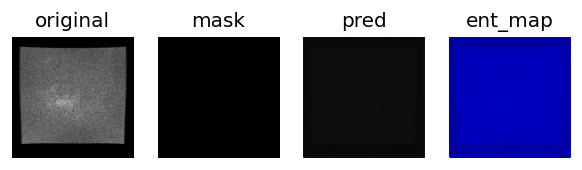

VAL Entropy Discrim. Acc:  1.0
VAL Entropy Adversarial Acc: 0
VAL Feature Discrim. Acc:  0.603448275862069
VAL Feature Adversarial Acc: 0
VAL AVG TRAIN SRC DICE: 0.9834760192781686
VAL AVG TRAIN TRG DICE: 0



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0304_ge_3_57_F.nii.gz Surface Dice: 0.9882803528966996 | SD at tol: 0.9635216199708195 | HD: 1.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0313_ge_3_34_M.nii.gz Surface Dice: 0.9896194234186423 | SD at tol: 0.9645726302602594 | HD: 1.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0311_ge_3_50_M.nii.gz Surface Dice: 0.9884629617306367 | SD at tol: 0.9579498803080242 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0357_ge_3_55_F.nii.gz Surface Dice: 0.9885341893155082 | SD at tol: 0.9654237478168032 | HD: 1.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0326_ge_3_55_M.nii.gz Surface Dice: 0.9880738603202253 | SD at tol: 0.9581241816059053 | HD: 1.0


  0%|          | 0/163 [00:00<?, ?it/s]

shapes:  (164, 288, 288)
CC0332_ge_3_53_F.nii.gz Surface Dice: 0.9881928349115953 | SD at tol: 0.9586528839556844 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0324_ge_3_56_M.nii.gz Surface Dice: 0.9865935927972729 | SD at tol: 0.9379297211241459 | HD: 1.7320508075688772


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0346_ge_3_43_M.nii.gz Surface Dice: 0.9861100028595744 | SD at tol: 0.9443734535441284 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0315_ge_3_59_M.nii.gz Surface Dice: 0.9890142666481752 | SD at tol: 0.965594975701444 | HD: 1.0


  0%|          | 0/187 [00:00<?, ?it/s]

shapes:  (188, 288, 288)
CC0355_ge_3_55_F.nii.gz Surface Dice: 0.987484268923248 | SD at tol: 0.9510197136710676 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0356_ge_3_61_F.nii.gz Surface Dice: 0.9894051411209754 | SD at tol: 0.9689301505875303 | HD: 1.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0305_ge_3_59_M.nii.gz Surface Dice: 0.9861174074872837 | SD at tol: 0.9486308609954776 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0303_ge_3_53_M.nii.gz Surface Dice: 0.9864387280720109 | SD at tol: 0.9502682818418804 | HD: 1.4142135623730951

ge vol metrics for epoch -1
AVG VOLUMETRIC DICE : 0.9878713100386037 | SD AT TOL: 0.9565378539525515 | HD: 1.2474870909082652 #########

######## TRG VAL #########
TRG VAL: -1 , 30 / 248  || Combined Seg Loss: 0.0 ( 0.0 + 0.7 + 0.67 + 0.02 )  || Feat Disc Loss: 0.69  || Ent Disc Loss: 0.72


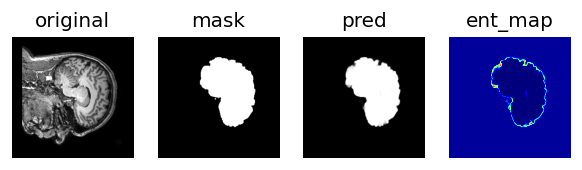

VAL Entropy Discrim. Acc:  0.0
VAL Entropy Adversarial Acc: 1.0
VAL Feature Discrim. Acc:  0.2601010101010101
VAL Feature Adversarial Acc: 0.73989898989899
VAL AVG TRAIN SRC DICE: 0
VAL AVG TRAIN TRG DICE: 0.8548339141139868



  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0066_philips_3_46_F.nii.gz Surface Dice: 0.9718003468042719 | SD at tol: 0.8542404995545549 | HD: 13.152946437965905


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0085_philips_3_71_M.nii.gz Surface Dice: 0.8693786195815172 | SD at tol: 0.5183600660615407 | HD: 15.264337522473747


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0110_philips_3_44_F.nii.gz Surface Dice: 0.9562061364667569 | SD at tol: 0.8019158369811773 | HD: 17.233687939614086


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0071_philips_3_56_M.nii.gz Surface Dice: 0.9635247105400209 | SD at tol: 0.8181405892142256 | HD: 15.556349186104045


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0078_philips_3_42_M.nii.gz Surface Dice: 0.8930328093739067 | SD at tol: 0.6566944752793258 | HD: 20.0


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0108_philips_3_51_M.nii.gz Surface Dice: 0.709393562109304 | SD at tol: 0.393340975330141 | HD: 19.79898987322333


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0075_philips_3_41_M.nii.gz Surface Dice: 0.9607201535983001 | SD at tol: 0.7815005205761814 | HD: 24.698178070456937


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0088_philips_3_51_F.nii.gz Surface Dice: 0.9489026066421865 | SD at tol: 0.7765938521903075 | HD: 22.561028345356956


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0092_philips_3_60_F.nii.gz Surface Dice: 0.8109616835579845 | SD at tol: 0.4564988228151007 | HD: 21.2602916254693


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0106_philips_3_41_F.nii.gz Surface Dice: 0.9151103153797405 | SD at tol: 0.5996249208543578 | HD: 17.11724276862369


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0083_philips_3_66_M.nii.gz Surface Dice: 0.6262730077329646 | SD at tol: 0.36029978928764 | HD: 34.95711658589707

philips vol metrics for epoch -1
AVG VOLUMETRIC DICE : 0.8750276319806322 | SD AT TOL: 0.6379282134676866 | HD: 20.14546985047137 #########

#########################################################################
EPOCH: 0 :( 0.001 0.001 )
SEG INITIAL 0.0001 0.0001
Feat DISC INITIAL 0.0001 0.0001
Ent DISC INITIAL 0.0001 0.0001


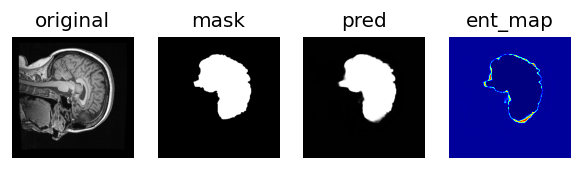

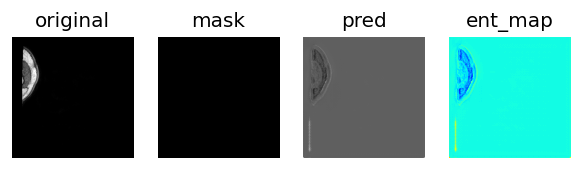

0 , 0 / 248  || Combined Seg Loss: 0.02 ( 0.02 + L1* 0.69 + L2* 0.67 + L3* 0.03 )  || Feat Disc Loss: 0.7  || Ent Disc Loss: 0.69
0 , 30 / 248  || Combined Seg Loss: 0.02 ( 0.02 + L1* 2.8 + L2* 0.67 + L3* 0.03 )  || Feat Disc Loss: 0.2  || Ent Disc Loss: 0.69


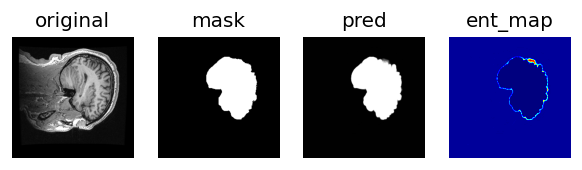

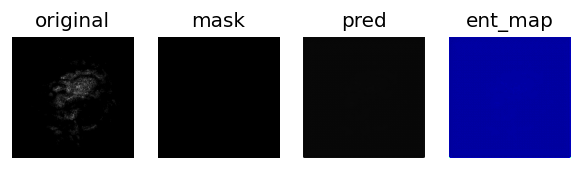

0 , 60 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.85 + L2* 0.66 + L3* 0.03 )  || Feat Disc Loss: 0.27  || Ent Disc Loss: 0.7
0 , 90 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 1.56 + L2* 0.67 + L3* 0.03 )  || Feat Disc Loss: 0.36  || Ent Disc Loss: 0.69


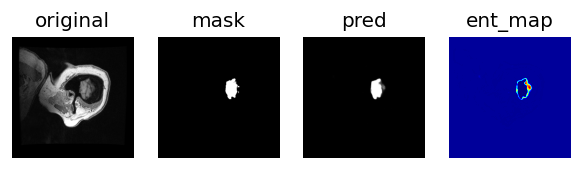

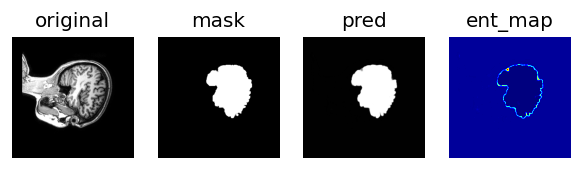

0 , 120 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.04 + L2* 0.7 + L3* 0.03 )  || Feat Disc Loss: 0.26  || Ent Disc Loss: 0.69


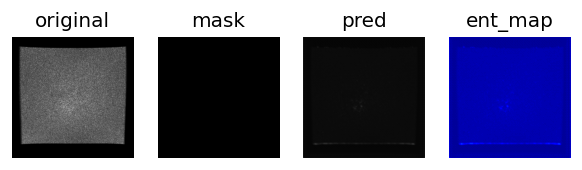

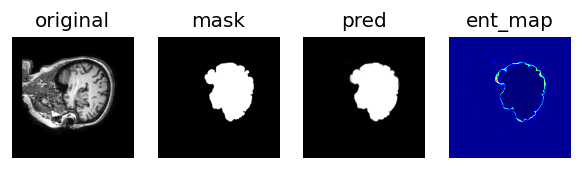

0 , 150 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.78 + L2* 1.52 + L3* 0.03 )  || Feat Disc Loss: 0.27  || Ent Disc Loss: 0.52
0 , 180 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 1.8 + L2* 1.77 + L3* 0.03 )  || Feat Disc Loss: 0.31  || Ent Disc Loss: 0.47


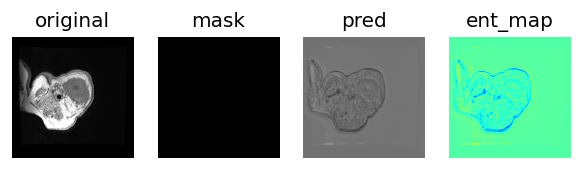

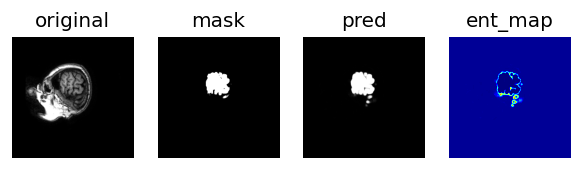

0 , 210 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.68 + L2* 1.49 + L3* 0.03 )  || Feat Disc Loss: 0.23  || Ent Disc Loss: 0.48
0 , 240 / 248  || Combined Seg Loss: 0.02 ( 0.02 + L1* 3.36 + L2* 1.6 + L3* 0.02 )  || Feat Disc Loss: 0.16  || Ent Disc Loss: 0.58
Entropy Discrim. Acc:  0.6125221127116502 ( Src: 0.895895153313551 , Trg: 0.31640826873385014 )
Entropy Adversarial Acc: 0.6835917312661499
Feature Discrim. Acc:  0.8967020470053071 ( Src: 0.9172848664688428 , Trg: 0.8751937984496124 )
Feature Adversarial Acc: 0.1248062015503876
AVG TRAIN SRC DICE: 0.9884510155647032
AVG TRAIN TRG DICE: 0.9642260370235289

######## SRC VAL #########
SRC VAL: 0 , 30 / 248  || Combined Seg Loss: 0.02 ( 0.02 + 0.0 + 0.0 + 0.01 )  || Feat Disc Loss: 0.46  || Ent Disc Loss: 0.14


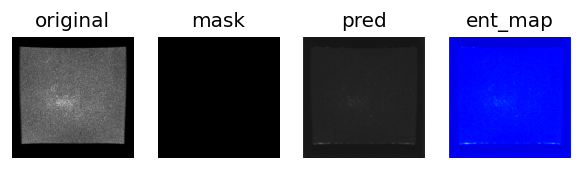

VAL Entropy Discrim. Acc:  0.9126175548589341
VAL Entropy Adversarial Acc: 0
VAL Feature Discrim. Acc:  0.9134012539184952
VAL Feature Adversarial Acc: 0
VAL AVG TRAIN SRC DICE: 0.9810368712991476
VAL AVG TRAIN TRG DICE: 0



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0304_ge_3_57_F.nii.gz Surface Dice: 0.9881628635662021 | SD at tol: 0.9609636394720448 | HD: 1.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0313_ge_3_34_M.nii.gz Surface Dice: 0.9874717081613633 | SD at tol: 0.9405575608177883 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0311_ge_3_50_M.nii.gz Surface Dice: 0.9868303763275831 | SD at tol: 0.9367771053566702 | HD: 1.7320508075688772


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0357_ge_3_55_F.nii.gz Surface Dice: 0.9876799813295829 | SD at tol: 0.9536288908164162 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0326_ge_3_55_M.nii.gz Surface Dice: 0.9865649673309976 | SD at tol: 0.9444114277972324 | HD: 1.4142135623730951


  0%|          | 0/163 [00:00<?, ?it/s]

shapes:  (164, 288, 288)
CC0332_ge_3_53_F.nii.gz Surface Dice: 0.9873120335640061 | SD at tol: 0.9471029597194733 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0324_ge_3_56_M.nii.gz Surface Dice: 0.982946787632611 | SD at tol: 0.8910518884621389 | HD: 3.7416573867739413


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0346_ge_3_43_M.nii.gz Surface Dice: 0.9879373855887661 | SD at tol: 0.9534921254711605 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0315_ge_3_59_M.nii.gz Surface Dice: 0.9872554744002607 | SD at tol: 0.9439197896402162 | HD: 1.4142135623730951


  0%|          | 0/187 [00:00<?, ?it/s]

shapes:  (188, 288, 288)
CC0355_ge_3_55_F.nii.gz Surface Dice: 0.9853172172173345 | SD at tol: 0.927910327966833 | HD: 2.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0356_ge_3_61_F.nii.gz Surface Dice: 0.9874543668370199 | SD at tol: 0.9457869808420175 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0305_ge_3_59_M.nii.gz Surface Dice: 0.9816406655240483 | SD at tol: 0.9001058270639863 | HD: 2.449489742783178


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0303_ge_3_53_M.nii.gz Surface Dice: 0.9856138164021969 | SD at tol: 0.9443861549442617 | HD: 1.4142135623730951

ge vol metrics for epoch 0
AVG VOLUMETRIC DICE : 0.9863221264524594 | SD AT TOL: 0.9376995906438645 | HD: 1.710531264316212 #########

######## TRG VAL #########
TRG VAL: 0 , 30 / 248  || Combined Seg Loss: 0.0 ( 0.0 + 2.23 + 2.69 + 0.01 )  || Feat Disc Loss: 0.24  || Ent Disc Loss: 0.24


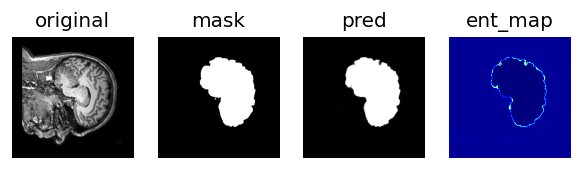

VAL Entropy Discrim. Acc:  0.5237373737373737
VAL Entropy Adversarial Acc: 0.4762626262626263
VAL Feature Discrim. Acc:  0.8292929292929293
VAL Feature Adversarial Acc: 0.1707070707070707
VAL AVG TRAIN SRC DICE: 0
VAL AVG TRAIN TRG DICE: 0.9160203004479955



  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0066_philips_3_46_F.nii.gz Surface Dice: 0.9815640428232191 | SD at tol: 0.8980506159772921 | HD: 9.433981132056603


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0085_philips_3_71_M.nii.gz Surface Dice: 0.9351836688991063 | SD at tol: 0.6810560054570438 | HD: 13.601470508735444


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0110_philips_3_44_F.nii.gz Surface Dice: 0.9816446726238934 | SD at tol: 0.8930170066951163 | HD: 10.0


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0071_philips_3_56_M.nii.gz Surface Dice: 0.9744022956899523 | SD at tol: 0.8428258445390687 | HD: 11.357816691600547


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0078_philips_3_42_M.nii.gz Surface Dice: 0.9676845675322566 | SD at tol: 0.7827089408597782 | HD: 18.466185312619388


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0108_philips_3_51_M.nii.gz Surface Dice: 0.9210143701283676 | SD at tol: 0.6726331576671375 | HD: 21.02379604162864


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0075_philips_3_41_M.nii.gz Surface Dice: 0.9750078606945793 | SD at tol: 0.8456447896613934 | HD: 12.727922061357855


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0088_philips_3_51_F.nii.gz Surface Dice: 0.9708653473177149 | SD at tol: 0.8435208837327872 | HD: 17.146428199482248


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0092_philips_3_60_F.nii.gz Surface Dice: 0.9245090449017722 | SD at tol: 0.6245721865952341 | HD: 11.0


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0106_philips_3_41_F.nii.gz Surface Dice: 0.9671245169746986 | SD at tol: 0.7891525135398585 | HD: 16.24807680927192


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0083_philips_3_66_M.nii.gz Surface Dice: 0.8702573637191218 | SD at tol: 0.5479479419246338 | HD: 15.524174696260024

philips vol metrics for epoch 0
AVG VOLUMETRIC DICE : 0.951750704664062 | SD AT TOL: 0.7655572624226676 | HD: 14.229986495728424 #########
SEG END 7.500000000000001e-05 0.0001
Feat DISC END 7.500000000000001e-05 0.0001
Ent DISC END 7.500000000000001e-05 0.0001

#########################################################################
EPOCH: 1 :( 0.001 0.001 )
SEG INITIAL 7.500000000000001e-05 0.0001
Feat DISC INITIAL 7.500000000000001e-05 0.0001
Ent DISC INITIAL 7.500000000000001e-05 0.0001


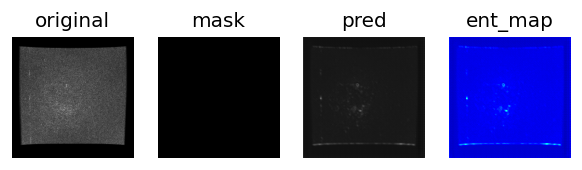

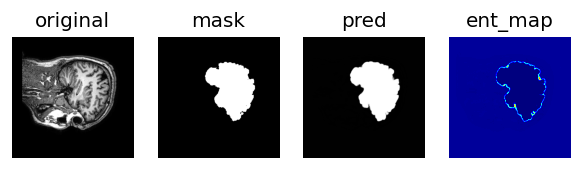

1 , 0 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.79 + L2* 1.86 + L3* 0.03 )  || Feat Disc Loss: 0.25  || Ent Disc Loss: 0.45
1 , 30 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.04 + L2* 1.79 + L3* 0.02 )  || Feat Disc Loss: 0.1  || Ent Disc Loss: 0.48


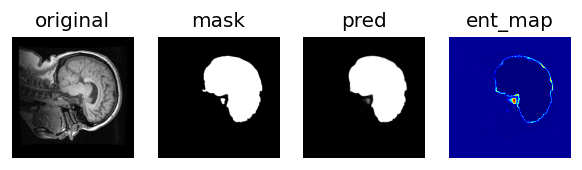

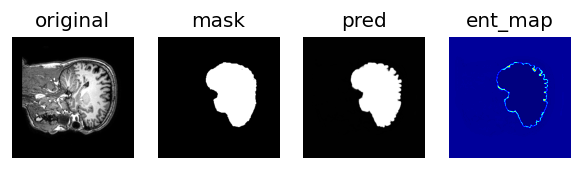

1 , 60 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.49 + L2* 1.75 + L3* 0.03 )  || Feat Disc Loss: 0.16  || Ent Disc Loss: 0.45
1 , 90 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.3 + L2* 2.14 + L3* 0.03 )  || Feat Disc Loss: 0.15  || Ent Disc Loss: 0.4


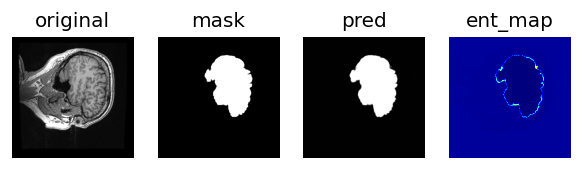

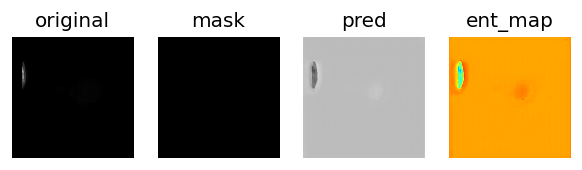

1 , 120 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.56 + L2* 1.13 + L3* 0.03 )  || Feat Disc Loss: 0.13  || Ent Disc Loss: 0.53


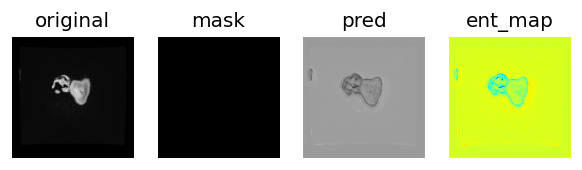

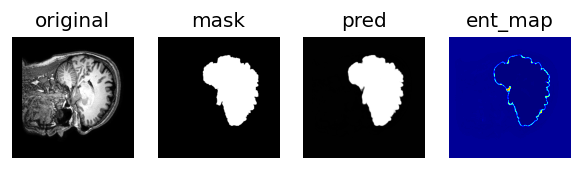

1 , 150 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.22 + L2* 2.49 + L3* 0.02 )  || Feat Disc Loss: 0.14  || Ent Disc Loss: 0.4
1 , 180 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.87 + L2* 2.32 + L3* 0.02 )  || Feat Disc Loss: 0.24  || Ent Disc Loss: 0.49


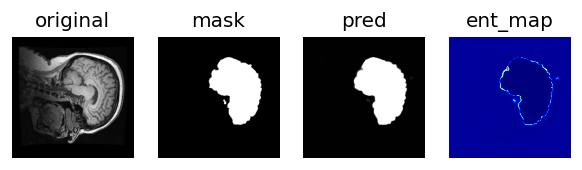

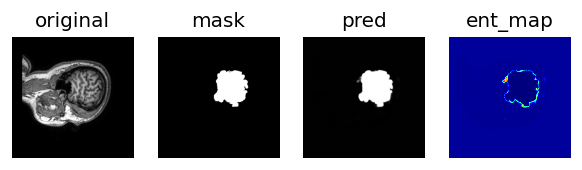

1 , 210 / 248  || Combined Seg Loss: 0.02 ( 0.02 + L1* 2.71 + L2* 2.2 + L3* 0.02 )  || Feat Disc Loss: 0.18  || Ent Disc Loss: 0.48
1 , 240 / 248  || Combined Seg Loss: 0.03 ( 0.03 + L1* 3.84 + L2* 2.32 + L3* 0.03 )  || Feat Disc Loss: 0.31  || Ent Disc Loss: 0.38
Entropy Discrim. Acc:  0.7437452615617892 ( Src: 0.8438427299703264 , Trg: 0.6391472868217054 )
Entropy Adversarial Acc: 0.3608527131782946
Feature Discrim. Acc:  0.9136972453879202 ( Src: 0.9230959446092978 , Trg: 0.9038759689922481 )
Feature Adversarial Acc: 0.09612403100775194
AVG TRAIN SRC DICE: 0.9879388571266206
AVG TRAIN TRG DICE: 0.9661379038326202

######## SRC VAL #########
SRC VAL: 1 , 30 / 248  || Combined Seg Loss: 0.02 ( 0.02 + 0.0 + 0.0 + 0.01 )  || Feat Disc Loss: 0.0  || Ent Disc Loss: 0.13


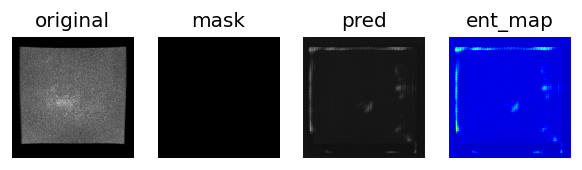

VAL Entropy Discrim. Acc:  0.9028213166144201
VAL Entropy Adversarial Acc: 0
VAL Feature Discrim. Acc:  0.6057993730407524
VAL Feature Adversarial Acc: 0
VAL AVG TRAIN SRC DICE: 0.9811509493738413
VAL AVG TRAIN TRG DICE: 0



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0304_ge_3_57_F.nii.gz Surface Dice: 0.9884163567726932 | SD at tol: 0.9667683994754044 | HD: 1.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0313_ge_3_34_M.nii.gz Surface Dice: 0.9877753292254363 | SD at tol: 0.9459719177579424 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0311_ge_3_50_M.nii.gz Surface Dice: 0.9865993792681444 | SD at tol: 0.9348244043394474 | HD: 1.7320508075688772


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0357_ge_3_55_F.nii.gz Surface Dice: 0.9877080982405193 | SD at tol: 0.955958625012556 | HD: 1.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0326_ge_3_55_M.nii.gz Surface Dice: 0.9858085453696068 | SD at tol: 0.9369090420797198 | HD: 1.4142135623730951


  0%|          | 0/163 [00:00<?, ?it/s]

shapes:  (164, 288, 288)
CC0332_ge_3_53_F.nii.gz Surface Dice: 0.9868296664017592 | SD at tol: 0.9444107833822559 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0324_ge_3_56_M.nii.gz Surface Dice: 0.9827301723561457 | SD at tol: 0.8903130320832257 | HD: 2.8284271247461903


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0346_ge_3_43_M.nii.gz Surface Dice: 0.9879285398906361 | SD at tol: 0.9537891927878551 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0315_ge_3_59_M.nii.gz Surface Dice: 0.9865953698818775 | SD at tol: 0.9377673064980164 | HD: 1.4142135623730951


  0%|          | 0/187 [00:00<?, ?it/s]

shapes:  (188, 288, 288)
CC0355_ge_3_55_F.nii.gz Surface Dice: 0.9850586059769476 | SD at tol: 0.9254969577573351 | HD: 2.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0356_ge_3_61_F.nii.gz Surface Dice: 0.9873583403753706 | SD at tol: 0.946322394024664 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0305_ge_3_59_M.nii.gz Surface Dice: 0.9810005692331658 | SD at tol: 0.8879076793440609 | HD: 2.23606797749979


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0303_ge_3_53_M.nii.gz Surface Dice: 0.9855425768436211 | SD at tol: 0.9459703248894308 | HD: 1.4142135623730951

ge vol metrics for epoch 1
AVG VOLUMETRIC DICE : 0.9861039653719942 | SD AT TOL: 0.9363392353409165 | HD: 1.5920031420328096 #########

######## TRG VAL #########
TRG VAL: 1 , 30 / 248  || Combined Seg Loss: 0.0 ( 0.0 + 2.75 + 1.27 + 0.01 )  || Feat Disc Loss: 0.13  || Ent Disc Loss: 0.46


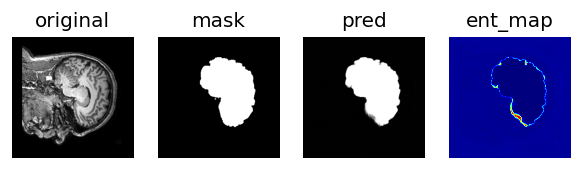

VAL Entropy Discrim. Acc:  0.5590909090909091
VAL Entropy Adversarial Acc: 0.4409090909090909
VAL Feature Discrim. Acc:  1.0
VAL Feature Adversarial Acc: 0.0
VAL AVG TRAIN SRC DICE: 0
VAL AVG TRAIN TRG DICE: 0.9197711758881411



  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0066_philips_3_46_F.nii.gz Surface Dice: 0.9659752988650274 | SD at tol: 0.8220873601740117 | HD: 13.038404810405298


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0085_philips_3_71_M.nii.gz Surface Dice: 0.9063135977995491 | SD at tol: 0.6275578092376618 | HD: 13.564659966250536


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0110_philips_3_44_F.nii.gz Surface Dice: 0.9703126690556145 | SD at tol: 0.8181881752357401 | HD: 13.638181696985855


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0071_philips_3_56_M.nii.gz Surface Dice: 0.9692394339679297 | SD at tol: 0.8102014208527147 | HD: 13.038404810405298


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0078_philips_3_42_M.nii.gz Surface Dice: 0.9536553747046921 | SD at tol: 0.7416402824419669 | HD: 21.118712081942874


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0108_philips_3_51_M.nii.gz Surface Dice: 0.8849671738036541 | SD at tol: 0.6279589310231045 | HD: 20.248456731316587


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0075_philips_3_41_M.nii.gz Surface Dice: 0.9668961508839741 | SD at tol: 0.8028494307195626 | HD: 16.822603841260722


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0088_philips_3_51_F.nii.gz Surface Dice: 0.9573905798297914 | SD at tol: 0.7705148441724604 | HD: 20.248456731316587


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0092_philips_3_60_F.nii.gz Surface Dice: 0.8983748409106314 | SD at tol: 0.572382327330998 | HD: 12.041594578792296


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0106_philips_3_41_F.nii.gz Surface Dice: 0.9468238714217714 | SD at tol: 0.7046261147133542 | HD: 17.916472867168917


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0083_philips_3_66_M.nii.gz Surface Dice: 0.8580242585711281 | SD at tol: 0.5476889220973878 | HD: 15.033296378372908

philips vol metrics for epoch 1
AVG VOLUMETRIC DICE : 0.9343612045285239 | SD AT TOL: 0.7132450561817238 | HD: 16.064476772201626 #########
SEG END 5.6250000000000005e-05 0.0001
Feat DISC END 5.6250000000000005e-05 0.0001
Ent DISC END 5.6250000000000005e-05 0.0001

#########################################################################
EPOCH: 2 :( 0.001 0.001 )
SEG INITIAL 5.6250000000000005e-05 0.0001
Feat DISC INITIAL 5.6250000000000005e-05 0.0001
Ent DISC INITIAL 5.6250000000000005e-05 0.0001


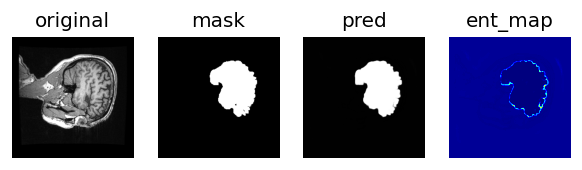

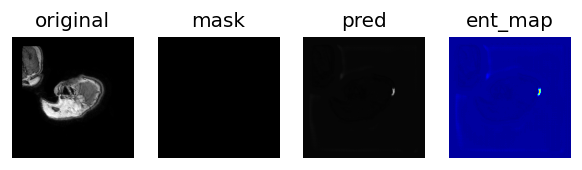

2 , 0 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.34 + L2* 1.16 + L3* 0.02 )  || Feat Disc Loss: 0.14  || Ent Disc Loss: 0.51
2 , 30 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 4.17 + L2* 1.79 + L3* 0.03 )  || Feat Disc Loss: 0.14  || Ent Disc Loss: 0.45


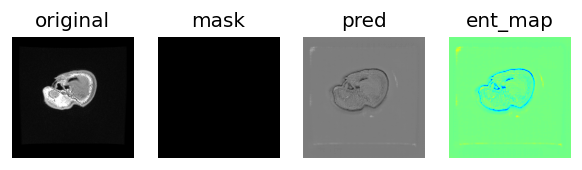

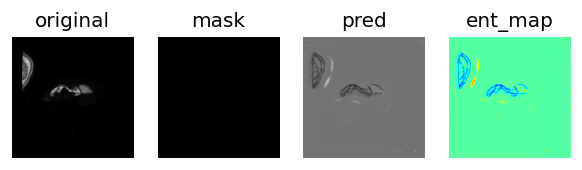

2 , 60 / 248  || Combined Seg Loss: 0.03 ( 0.03 + L1* 3.25 + L2* 1.92 + L3* 0.03 )  || Feat Disc Loss: 0.19  || Ent Disc Loss: 0.47
2 , 90 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.77 + L2* 2.43 + L3* 0.02 )  || Feat Disc Loss: 0.13  || Ent Disc Loss: 0.37


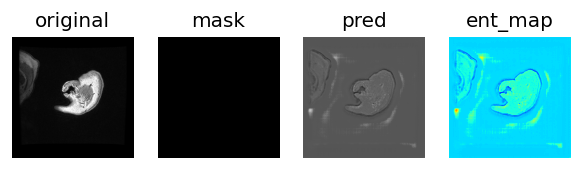

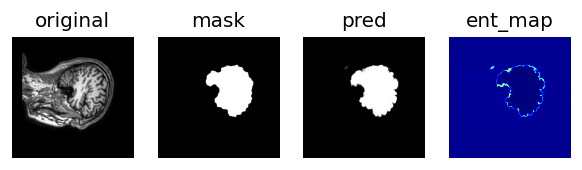

2 , 120 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.11 + L2* 2.51 + L3* 0.03 )  || Feat Disc Loss: 0.43  || Ent Disc Loss: 0.29


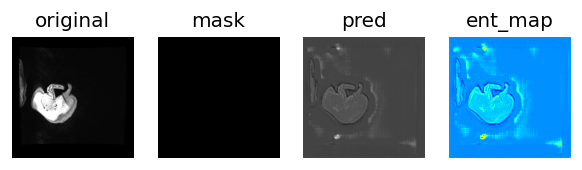

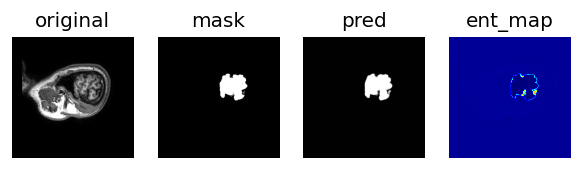

2 , 150 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.84 + L2* 2.7 + L3* 0.03 )  || Feat Disc Loss: 0.14  || Ent Disc Loss: 0.39
2 , 180 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 1.85 + L2* 1.6 + L3* 0.03 )  || Feat Disc Loss: 0.32  || Ent Disc Loss: 0.42


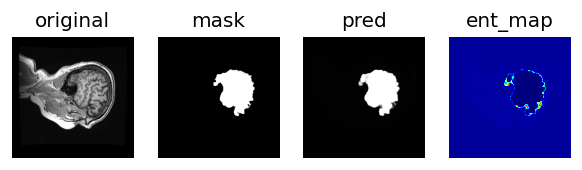

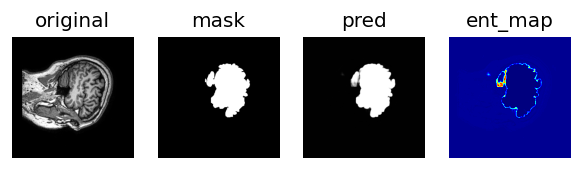

2 , 210 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.56 + L2* 2.08 + L3* 0.03 )  || Feat Disc Loss: 0.28  || Ent Disc Loss: 0.47
2 , 240 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.16 + L2* 2.07 + L3* 0.03 )  || Feat Disc Loss: 0.21  || Ent Disc Loss: 0.48
Entropy Discrim. Acc:  0.7667424816780389 ( Src: 0.8524975272007913 , Trg: 0.6771317829457364 )
Entropy Adversarial Acc: 0.32286821705426355
Feature Discrim. Acc:  0.9230477634571645 ( Src: 0.9342235410484668 , Trg: 0.9113695090439277 )
Feature Adversarial Acc: 0.08863049095607235
AVG TRAIN SRC DICE: 0.9880795091871293
AVG TRAIN TRG DICE: 0.9671350539691986

######## SRC VAL #########
SRC VAL: 2 , 30 / 248  || Combined Seg Loss: 0.02 ( 0.02 + 0.0 + 0.0 + 0.01 )  || Feat Disc Loss: 0.02  || Ent Disc Loss: 0.01


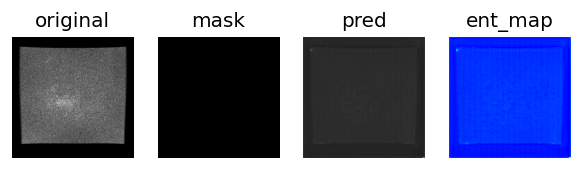

VAL Entropy Discrim. Acc:  0.950626959247649
VAL Entropy Adversarial Acc: 0
VAL Feature Discrim. Acc:  0.747257053291536
VAL Feature Adversarial Acc: 0
VAL AVG TRAIN SRC DICE: 0.974669650203678
VAL AVG TRAIN TRG DICE: 0



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0304_ge_3_57_F.nii.gz Surface Dice: 0.9881208952705078 | SD at tol: 0.9595372492736949 | HD: 1.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0313_ge_3_34_M.nii.gz Surface Dice: 0.9875392439586804 | SD at tol: 0.942610765504979 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0311_ge_3_50_M.nii.gz Surface Dice: 0.9865919948444221 | SD at tol: 0.9347733323273574 | HD: 1.7320508075688772


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0357_ge_3_55_F.nii.gz Surface Dice: 0.9876362826808914 | SD at tol: 0.9544902994839298 | HD: 1.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0326_ge_3_55_M.nii.gz Surface Dice: 0.986082118270181 | SD at tol: 0.9403941862081399 | HD: 1.4142135623730951


  0%|          | 0/163 [00:00<?, ?it/s]

shapes:  (164, 288, 288)
CC0332_ge_3_53_F.nii.gz Surface Dice: 0.9864093439925746 | SD at tol: 0.939270784425201 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0324_ge_3_56_M.nii.gz Surface Dice: 0.9825611300611495 | SD at tol: 0.8905962488981367 | HD: 3.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0346_ge_3_43_M.nii.gz Surface Dice: 0.9881411675845448 | SD at tol: 0.9488365430595125 | HD: 1.7320508075688772


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0315_ge_3_59_M.nii.gz Surface Dice: 0.9861299368301583 | SD at tol: 0.930352237077232 | HD: 1.7320508075688772


  0%|          | 0/187 [00:00<?, ?it/s]

shapes:  (188, 288, 288)
CC0355_ge_3_55_F.nii.gz Surface Dice: 0.9843243601282665 | SD at tol: 0.9174210804744696 | HD: 2.23606797749979


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0356_ge_3_61_F.nii.gz Surface Dice: 0.9874801814668106 | SD at tol: 0.9480661996366717 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0305_ge_3_59_M.nii.gz Surface Dice: 0.9794683633099082 | SD at tol: 0.8765407014886846 | HD: 3.1622776601683795


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0303_ge_3_53_M.nii.gz Surface Dice: 0.985029622518418 | SD at tol: 0.9402094893695302 | HD: 1.4142135623730951

ge vol metrics for epoch 2
AVG VOLUMETRIC DICE : 0.9858088185320395 | SD AT TOL: 0.93254608594058 | HD: 1.743505067095406 #########

######## TRG VAL #########
TRG VAL: 2 , 30 / 248  || Combined Seg Loss: 0.0 ( 0.0 + 0.8 + 1.11 + 0.01 )  || Feat Disc Loss: 0.73  || Ent Disc Loss: 0.61


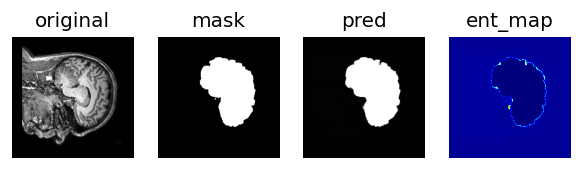

VAL Entropy Discrim. Acc:  0.5580808080808081
VAL Entropy Adversarial Acc: 0.44191919191919193
VAL Feature Discrim. Acc:  0.9388888888888889
VAL Feature Adversarial Acc: 0.06111111111111111
VAL AVG TRAIN SRC DICE: 0
VAL AVG TRAIN TRG DICE: 0.8627488394244515



  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0066_philips_3_46_F.nii.gz Surface Dice: 0.9841983115324439 | SD at tol: 0.9267267615710103 | HD: 2.449489742783178


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0085_philips_3_71_M.nii.gz Surface Dice: 0.9398841409000036 | SD at tol: 0.7024386249685596 | HD: 14.45683229480096


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0110_philips_3_44_F.nii.gz Surface Dice: 0.9827873589294157 | SD at tol: 0.8883446234662652 | HD: 14.177446878757825


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0071_philips_3_56_M.nii.gz Surface Dice: 0.9782682616213234 | SD at tol: 0.871506638821276 | HD: 9.055385138137417


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0078_philips_3_42_M.nii.gz Surface Dice: 0.9794423166874296 | SD at tol: 0.8710769816627022 | HD: 8.48528137423857


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0108_philips_3_51_M.nii.gz Surface Dice: 0.9541154863279908 | SD at tol: 0.7402150427116009 | HD: 19.313207915827967


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0075_philips_3_41_M.nii.gz Surface Dice: 0.976960815184782 | SD at tol: 0.8577596714776528 | HD: 8.0


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0088_philips_3_51_F.nii.gz Surface Dice: 0.9746946135704208 | SD at tol: 0.8560358878512889 | HD: 15.0


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0092_philips_3_60_F.nii.gz Surface Dice: 0.9410980935175268 | SD at tol: 0.6686207709551786 | HD: 11.0


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0106_philips_3_41_F.nii.gz Surface Dice: 0.9693807317432832 | SD at tol: 0.8014055998046515 | HD: 14.730919862656235


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0083_philips_3_66_M.nii.gz Surface Dice: 0.9166559727486773 | SD at tol: 0.655753135878284 | HD: 13.601470508735444

philips vol metrics for epoch 2
AVG VOLUMETRIC DICE : 0.9634078275239361 | SD AT TOL: 0.8036257944698609 | HD: 11.842730337812508 #########
SEG END 4.21875e-05 0.0001
Feat DISC END 4.21875e-05 0.0001
Ent DISC END 4.21875e-05 0.0001

#########################################################################
EPOCH: 3 :( 0.001 0.001 )
SEG INITIAL 4.21875e-05 0.0001
Feat DISC INITIAL 4.21875e-05 0.0001
Ent DISC INITIAL 4.21875e-05 0.0001


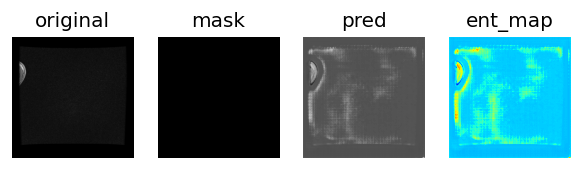

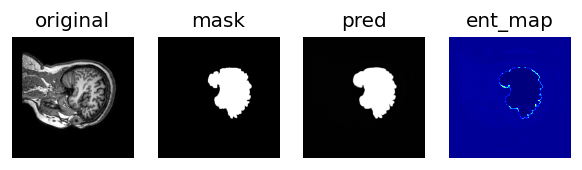

3 , 0 / 248  || Combined Seg Loss: 0.03 ( 0.03 + L1* 1.92 + L2* 1.76 + L3* 0.03 )  || Feat Disc Loss: 0.26  || Ent Disc Loss: 0.43
3 , 30 / 248  || Combined Seg Loss: 0.02 ( 0.02 + L1* 2.24 + L2* 3.04 + L3* 0.02 )  || Feat Disc Loss: 0.2  || Ent Disc Loss: 0.31


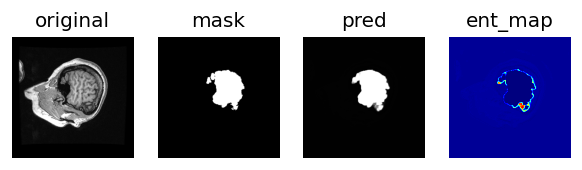

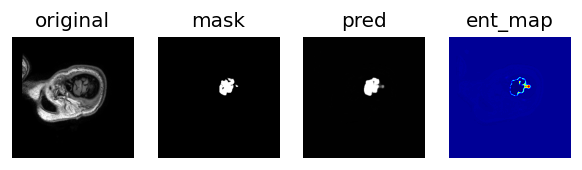

3 , 60 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.12 + L2* 2.84 + L3* 0.02 )  || Feat Disc Loss: 0.22  || Ent Disc Loss: 0.41
3 , 90 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.4 + L2* 1.74 + L3* 0.02 )  || Feat Disc Loss: 0.11  || Ent Disc Loss: 0.42


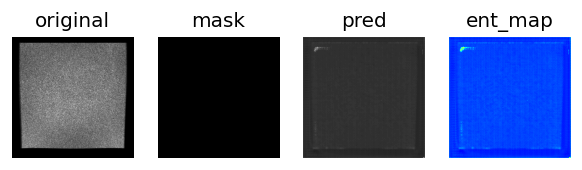

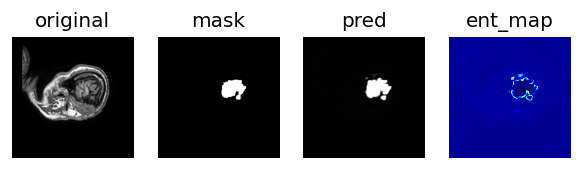

3 , 120 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.69 + L2* 1.83 + L3* 0.03 )  || Feat Disc Loss: 0.17  || Ent Disc Loss: 0.45


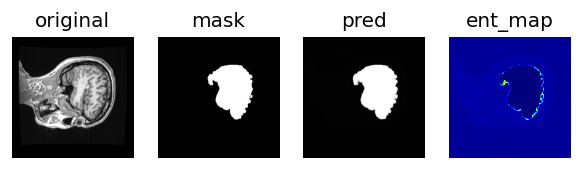

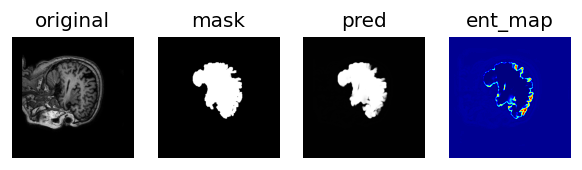

3 , 150 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 1.35 + L2* 1.71 + L3* 0.02 )  || Feat Disc Loss: 0.24  || Ent Disc Loss: 0.43
3 , 180 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 4.49 + L2* 3.18 + L3* 0.02 )  || Feat Disc Loss: 0.17  || Ent Disc Loss: 0.33


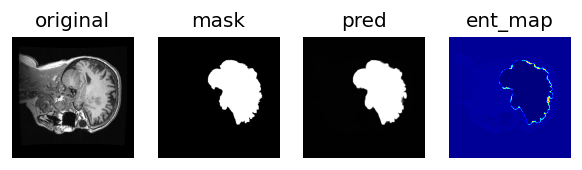

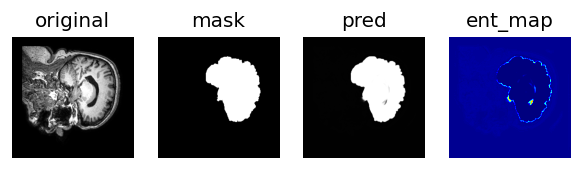

3 , 210 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.58 + L2* 2.35 + L3* 0.02 )  || Feat Disc Loss: 0.11  || Ent Disc Loss: 0.34
3 , 240 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.54 + L2* 2.29 + L3* 0.02 )  || Feat Disc Loss: 0.17  || Ent Disc Loss: 0.4
Entropy Discrim. Acc:  0.7886656557998484 ( Src: 0.8871167161226509 , Trg: 0.6857881136950904 )
Entropy Adversarial Acc: 0.31421188630490954
Feature Discrim. Acc:  0.9342936568107152 ( Src: 0.9357072205736894 , Trg: 0.9328165374677002 )
Feature Adversarial Acc: 0.06718346253229975
AVG TRAIN SRC DICE: 0.9880959326701779
AVG TRAIN TRG DICE: 0.9695045664425819

######## SRC VAL #########
SRC VAL: 3 , 30 / 248  || Combined Seg Loss: 0.02 ( 0.02 + 0.0 + 0.0 + 0.01 )  || Feat Disc Loss: 0.1  || Ent Disc Loss: 0.01


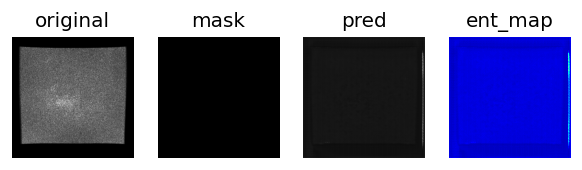

VAL Entropy Discrim. Acc:  0.9137931034482759
VAL Entropy Adversarial Acc: 0
VAL Feature Discrim. Acc:  0.7821316614420063
VAL Feature Adversarial Acc: 0
VAL AVG TRAIN SRC DICE: 0.979846503213048
VAL AVG TRAIN TRG DICE: 0



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0304_ge_3_57_F.nii.gz Surface Dice: 0.9882281691539796 | SD at tol: 0.9631537991808213 | HD: 1.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0313_ge_3_34_M.nii.gz Surface Dice: 0.9875635408003018 | SD at tol: 0.9466487396559308 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0311_ge_3_50_M.nii.gz Surface Dice: 0.9863992068071186 | SD at tol: 0.9332351945167845 | HD: 2.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0357_ge_3_55_F.nii.gz Surface Dice: 0.9872275238705706 | SD at tol: 0.952234028093139 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0326_ge_3_55_M.nii.gz Surface Dice: 0.985821568902358 | SD at tol: 0.9394977831890183 | HD: 1.4142135623730951


  0%|          | 0/163 [00:00<?, ?it/s]

shapes:  (164, 288, 288)
CC0332_ge_3_53_F.nii.gz Surface Dice: 0.9861376590441757 | SD at tol: 0.9391084411713659 | HD: 1.7320508075688772


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0324_ge_3_56_M.nii.gz Surface Dice: 0.9819522002380903 | SD at tol: 0.8836194352146225 | HD: 3.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0346_ge_3_43_M.nii.gz Surface Dice: 0.9875146987618455 | SD at tol: 0.9319404165407268 | HD: 3.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0315_ge_3_59_M.nii.gz Surface Dice: 0.9862795997778531 | SD at tol: 0.9344276400232868 | HD: 1.4142135623730951


  0%|          | 0/187 [00:00<?, ?it/s]

shapes:  (188, 288, 288)
CC0355_ge_3_55_F.nii.gz Surface Dice: 0.9841714026995583 | SD at tol: 0.9168660953412482 | HD: 2.23606797749979


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0356_ge_3_61_F.nii.gz Surface Dice: 0.9870578173177394 | SD at tol: 0.9460369544403702 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0305_ge_3_59_M.nii.gz Surface Dice: 0.9791192544364776 | SD at tol: 0.8719645712641922 | HD: 3.1622776601683795


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0303_ge_3_53_M.nii.gz Surface Dice: 0.9848716735769077 | SD at tol: 0.9396198657003921 | HD: 1.4142135623730951

ge vol metrics for epoch 3
AVG VOLUMETRIC DICE : 0.9855649473374597 | SD AT TOL: 0.9306425357178384 | HD: 1.8935136784212014 #########

######## TRG VAL #########
TRG VAL: 3 , 30 / 248  || Combined Seg Loss: 0.01 ( 0.0 + 4.81 + 1.87 + 0.01 )  || Feat Disc Loss: 0.01  || Ent Disc Loss: 0.28


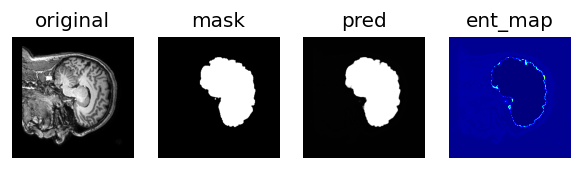

VAL Entropy Discrim. Acc:  0.6358585858585859
VAL Entropy Adversarial Acc: 0.36414141414141415
VAL Feature Discrim. Acc:  0.9949494949494949
VAL Feature Adversarial Acc: 0.005050505050505051
VAL AVG TRAIN SRC DICE: 0
VAL AVG TRAIN TRG DICE: 0.907361877290919



  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0066_philips_3_46_F.nii.gz Surface Dice: 0.9844854292700993 | SD at tol: 0.9319959784877118 | HD: 2.0


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0085_philips_3_71_M.nii.gz Surface Dice: 0.9493055453435878 | SD at tol: 0.7240025555791338 | HD: 12.083045973594572


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0110_philips_3_44_F.nii.gz Surface Dice: 0.9846658976587731 | SD at tol: 0.9252703019112489 | HD: 2.449489742783178


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0071_philips_3_56_M.nii.gz Surface Dice: 0.9794266301199395 | SD at tol: 0.8838709485873822 | HD: 4.69041575982343


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0078_philips_3_42_M.nii.gz Surface Dice: 0.9801030848614388 | SD at tol: 0.8767619780678382 | HD: 5.830951894845301


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0108_philips_3_51_M.nii.gz Surface Dice: 0.9604985671839665 | SD at tol: 0.7542530761827775 | HD: 19.209372712298546


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0075_philips_3_41_M.nii.gz Surface Dice: 0.9761377533730282 | SD at tol: 0.856380088018016 | HD: 8.54400374531753


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0088_philips_3_51_F.nii.gz Surface Dice: 0.976453531549895 | SD at tol: 0.8743350959774878 | HD: 8.94427190999916


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0092_philips_3_60_F.nii.gz Surface Dice: 0.9475079473944612 | SD at tol: 0.7038077999635679 | HD: 9.695359714832659


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0106_philips_3_41_F.nii.gz Surface Dice: 0.9702907355369672 | SD at tol: 0.8100103771156505 | HD: 10.246950765959598


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0083_philips_3_66_M.nii.gz Surface Dice: 0.9276869333550817 | SD at tol: 0.6782257849430157 | HD: 13.92838827718412

philips vol metrics for epoch 3
AVG VOLUMETRIC DICE : 0.9669601868770217 | SD AT TOL: 0.8199012713485301 | HD: 8.874750045148918 #########
SEG END 3.1640625e-05 0.0001
Feat DISC END 3.1640625e-05 0.0001
Ent DISC END 3.1640625e-05 0.0001

#########################################################################
EPOCH: 4 :( 0.001 0.001 )
SEG INITIAL 3.1640625e-05 0.0001
Feat DISC INITIAL 3.1640625e-05 0.0001
Ent DISC INITIAL 3.1640625e-05 0.0001


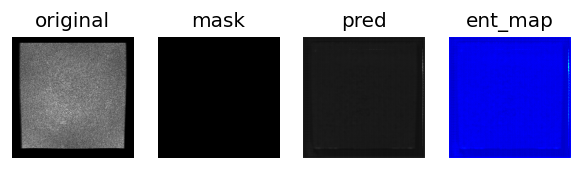

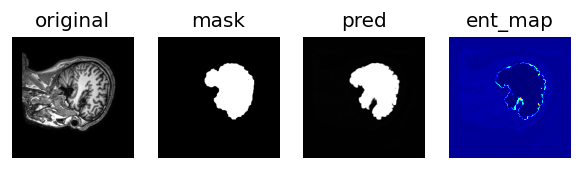

4 , 0 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.16 + L2* 2.62 + L3* 0.02 )  || Feat Disc Loss: 0.12  || Ent Disc Loss: 0.41
4 , 30 / 248  || Combined Seg Loss: 0.03 ( 0.03 + L1* 2.87 + L2* 3.11 + L3* 0.03 )  || Feat Disc Loss: 0.13  || Ent Disc Loss: 0.37


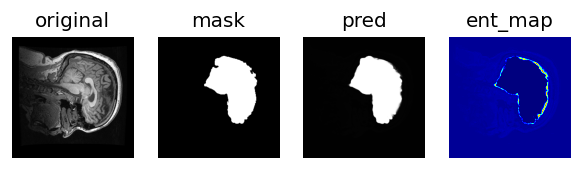

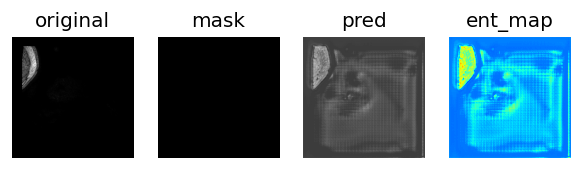

4 , 60 / 248  || Combined Seg Loss: 0.02 ( 0.02 + L1* 2.05 + L2* 1.68 + L3* 0.03 )  || Feat Disc Loss: 0.25  || Ent Disc Loss: 0.41
4 , 90 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.88 + L2* 1.16 + L3* 0.03 )  || Feat Disc Loss: 0.1  || Ent Disc Loss: 0.48


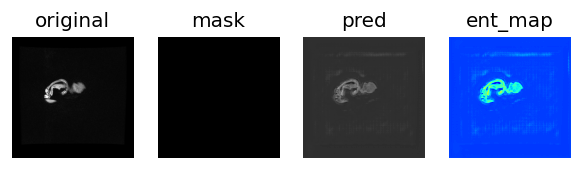

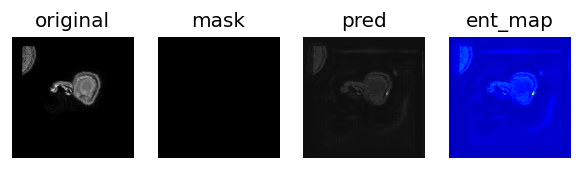

4 , 120 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 3.52 + L2* 2.85 + L3* 0.02 )  || Feat Disc Loss: 0.19  || Ent Disc Loss: 0.38


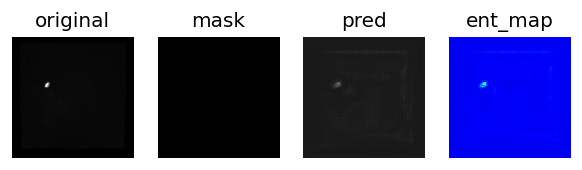

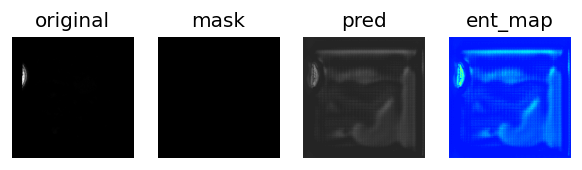

4 , 150 / 248  || Combined Seg Loss: 0.02 ( 0.02 + L1* 1.61 + L2* 1.81 + L3* 0.03 )  || Feat Disc Loss: 0.16  || Ent Disc Loss: 0.33
4 , 180 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.08 + L2* 2.54 + L3* 0.02 )  || Feat Disc Loss: 0.14  || Ent Disc Loss: 0.39


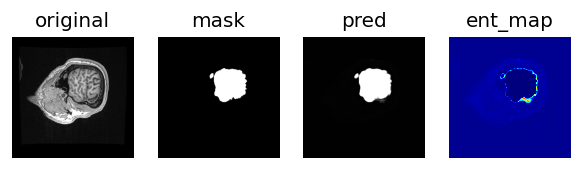

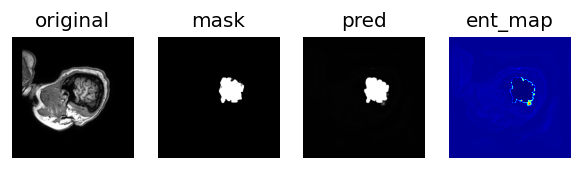

4 , 210 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.8 + L2* 3.04 + L3* 0.03 )  || Feat Disc Loss: 0.1  || Ent Disc Loss: 0.4
4 , 240 / 248  || Combined Seg Loss: 0.03 ( 0.02 + L1* 2.92 + L2* 3.0 + L3* 0.02 )  || Feat Disc Loss: 0.12  || Ent Disc Loss: 0.35
Entropy Discrim. Acc:  0.8232246651503664 ( Src: 0.878461918892186 , Trg: 0.7655038759689923 )
Entropy Adversarial Acc: 0.23449612403100775
Feature Discrim. Acc:  0.9619029567854435 ( Src: 0.9609297725024728 , Trg: 0.9629198966408269 )
Feature Adversarial Acc: 0.037080103359173125
AVG TRAIN SRC DICE: 0.9881684948359767
AVG TRAIN TRG DICE: 0.9718224507185721

######## SRC VAL #########
SRC VAL: 4 , 30 / 248  || Combined Seg Loss: 0.02 ( 0.02 + 0.0 + 0.0 + 0.01 )  || Feat Disc Loss: 0.01  || Ent Disc Loss: 0.0


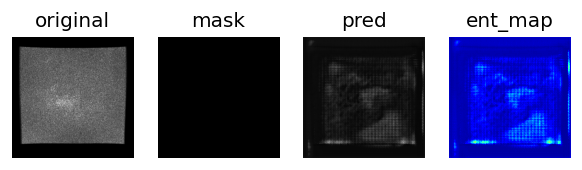

VAL Entropy Discrim. Acc:  0.9028213166144201
VAL Entropy Adversarial Acc: 0
VAL Feature Discrim. Acc:  0.5141065830721003
VAL Feature Adversarial Acc: 0
VAL AVG TRAIN SRC DICE: 0.9798455063253642
VAL AVG TRAIN TRG DICE: 0



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0304_ge_3_57_F.nii.gz Surface Dice: 0.9882024979169369 | SD at tol: 0.9639595288213446 | HD: 1.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0313_ge_3_34_M.nii.gz Surface Dice: 0.9876995458702912 | SD at tol: 0.9483669068740929 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0311_ge_3_50_M.nii.gz Surface Dice: 0.9866531015064265 | SD at tol: 0.936330982545424 | HD: 1.7320508075688772


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0357_ge_3_55_F.nii.gz Surface Dice: 0.9874516163283429 | SD at tol: 0.9542989548995109 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0326_ge_3_55_M.nii.gz Surface Dice: 0.9859082764228813 | SD at tol: 0.9403431042844803 | HD: 1.4142135623730951


  0%|          | 0/163 [00:00<?, ?it/s]

shapes:  (164, 288, 288)
CC0332_ge_3_53_F.nii.gz Surface Dice: 0.9864523341466708 | SD at tol: 0.9423909821789938 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0324_ge_3_56_M.nii.gz Surface Dice: 0.9826765533429713 | SD at tol: 0.8917209311146136 | HD: 2.8284271247461903


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0346_ge_3_43_M.nii.gz Surface Dice: 0.9879901567795113 | SD at tol: 0.9484425189826655 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0315_ge_3_59_M.nii.gz Surface Dice: 0.9870480793057169 | SD at tol: 0.9460920374744902 | HD: 1.4142135623730951


  0%|          | 0/187 [00:00<?, ?it/s]

shapes:  (188, 288, 288)
CC0355_ge_3_55_F.nii.gz Surface Dice: 0.9849211970681753 | SD at tol: 0.9253807308642855 | HD: 2.0


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0356_ge_3_61_F.nii.gz Surface Dice: 0.9875322547355052 | SD at tol: 0.9506315994621458 | HD: 1.4142135623730951


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0305_ge_3_59_M.nii.gz Surface Dice: 0.9801524519174303 | SD at tol: 0.8851525771739229 | HD: 2.8284271247461903


  0%|          | 0/199 [00:00<?, ?it/s]

shapes:  (200, 288, 288)
CC0303_ge_3_53_M.nii.gz Surface Dice: 0.9852774141234073 | SD at tol: 0.9446000067563658 | HD: 1.4142135623730951

ge vol metrics for epoch 4
AVG VOLUMETRIC DICE : 0.9859973445741744 | SD AT TOL: 0.9367469893409489 | HD: 1.6694318120035399 #########

######## TRG VAL #########
TRG VAL: 4 , 30 / 248  || Combined Seg Loss: 0.0 ( 0.0 + 3.72 + 0.96 + 0.01 )  || Feat Disc Loss: 0.04  || Ent Disc Loss: 1.0


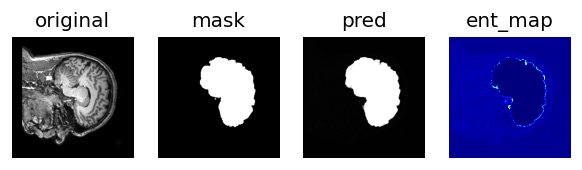

VAL Entropy Discrim. Acc:  0.8222222222222222
VAL Entropy Adversarial Acc: 0.17777777777777778
VAL Feature Discrim. Acc:  0.997979797979798
VAL Feature Adversarial Acc: 0.00202020202020202
VAL AVG TRAIN SRC DICE: 0
VAL AVG TRAIN TRG DICE: 0.9121748859451942



  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0066_philips_3_46_F.nii.gz Surface Dice: 0.9841949715899493 | SD at tol: 0.9300736176959201 | HD: 2.0


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0085_philips_3_71_M.nii.gz Surface Dice: 0.9532470773994856 | SD at tol: 0.7407665761904639 | HD: 9.848857801796104


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0110_philips_3_44_F.nii.gz Surface Dice: 0.9841875325510983 | SD at tol: 0.9219020165641822 | HD: 2.449489742783178


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0071_philips_3_56_M.nii.gz Surface Dice: 0.9798236677508131 | SD at tol: 0.8884749775276318 | HD: 3.605551275463989


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0078_philips_3_42_M.nii.gz Surface Dice: 0.9772139489219694 | SD at tol: 0.8559752608992169 | HD: 9.219544457292887


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0108_philips_3_51_M.nii.gz Surface Dice: 0.9612574301107354 | SD at tol: 0.7592091042969487 | HD: 17.291616465790582


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0075_philips_3_41_M.nii.gz Surface Dice: 0.9763969676734381 | SD at tol: 0.8575862314424962 | HD: 8.0


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0088_philips_3_51_F.nii.gz Surface Dice: 0.9768294157155586 | SD at tol: 0.8781130080071387 | HD: 6.4031242374328485


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0092_philips_3_60_F.nii.gz Surface Dice: 0.9490406117454117 | SD at tol: 0.7145221050881448 | HD: 8.774964387392123


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0106_philips_3_41_F.nii.gz Surface Dice: 0.9698052117860109 | SD at tol: 0.8093156946862541 | HD: 9.219544457292887


  0%|          | 0/179 [00:00<?, ?it/s]

shapes:  (180, 288, 288)
CC0083_philips_3_66_M.nii.gz Surface Dice: 0.9301308223559622 | SD at tol: 0.6603297823832484 | HD: 13.92838827718412

philips vol metrics for epoch 4
AVG VOLUMETRIC DICE : 0.9674661506909484 | SD AT TOL: 0.819660761343786 | HD: 8.249189191129883 #########
SEG END 2.373046875e-05 0.0001
Feat DISC END 2.373046875e-05 0.0001
Ent DISC END 2.373046875e-05 0.0001


In [ ]:
'''
ACCUMULATE STATS BEFORE RUN
'''


n = -1
'''
SRC EVAL DURING TRAINING
'''
print()
print("######## SRC VAL #########")
src_val_stats = val(n, models, lambdas, src_val_loader, src_val_stats, device, 'src')

print()
src_val_stats = Eval_Vol_Dice('src', src_domain, src_domain_type, 'val', segmenter, src_val_stats, n)

'''
TRG EVAL DURING TRAINING
'''
print()
print('######## TRG VAL #########')
trg_val_stats = val(n, models, lambdas, trg_val_loader, trg_val_stats, device, 'trg')

print()
trg_val_stats  = Eval_Vol_Dice('trg', trg_domain, trg_domain_type, 'val', segmenter, trg_val_stats, n)


for n in range( no_of_epochs): #no_of_epochs

  print()
  print("#########################################################################")
  print("EPOCH:",n,":(" ,lambda1, lambda2, ")")

  print("SEG INITIAL", seg_opt.state_dict()['param_groups'][0]['lr'], seg_opt.state_dict()['param_groups'][0]['initial_lr'])
  print("Feat DISC INITIAL", feat_disc_opt.state_dict()['param_groups'][0]['lr'], feat_disc_opt.state_dict()['param_groups'][0]['initial_lr'])
  print("Ent DISC INITIAL", ent_disc_opt.state_dict()['param_groups'][0]['lr'], ent_disc_opt.state_dict()['param_groups'][0]['initial_lr'])

  
  train_stats, models, optimizers = train( n, optimizers, models, lambdas, train_loader, train_stats, device )

  '''
  SRC EVAL DURING TRAINING
  '''
  print()
  print("######## SRC VAL #########")
  src_val_stats = val(n, models, lambdas, src_val_loader, src_val_stats, device, 'src')

  print()
  src_val_stats = Eval_Vol_Dice('src', src_domain, src_domain_type, 'val', segmenter, src_val_stats, n)

  '''
  TRG EVAL DURING TRAINING
  '''
  print()
  print('######## TRG VAL #########')
  trg_val_stats = val(n, models, lambdas, trg_val_loader, trg_val_stats, device, 'trg')


  print()
  trg_val_stats  = Eval_Vol_Dice('trg', trg_domain, trg_domain_type, 'val', segmenter, trg_val_stats, n)


  seg_scheduler.step()
  feat_disc_scheduler.step()
  ent_disc_scheduler.step()

  print("SEG END", seg_opt.state_dict()['param_groups'][0]['lr'], seg_opt.state_dict()['param_groups'][0]['initial_lr'])
  print("Feat DISC END", feat_disc_opt.state_dict()['param_groups'][0]['lr'], feat_disc_opt.state_dict()['param_groups'][0]['initial_lr'])
  print("Ent DISC END", ent_disc_opt.state_dict()['param_groups'][0]['lr'], ent_disc_opt.state_dict()['param_groups'][0]['initial_lr'])



# Save stats

In [ ]:
 print(n)

file_name= base_path + folder + 'train_stats_'+str(n)+'epochs.pkl'
f = open(file_name,'wb')
pickle.dump(train_stats,f)
f.close()

file_name= base_path + folder + 'src_val_stats_'+str(n)+'epochs.pkl'
f = open(file_name,'wb')
pickle.dump(src_val_stats,f)
f.close()

file_name= base_path + folder + 'trg_val_stats_'+str(n)+'epochs.pkl'
f = open(file_name,'wb')
pickle.dump(trg_val_stats,f)
f.close()

4


### Save model

In [ ]:
torch.save(segmenter,base_path + folder +'ge3_adv_segmodel_'+str(n)+'epochs.pkl' )
torch.save(feat_discriminator,base_path + folder +'ge3_adv_feat_discmodel_'+str(n)+'epochs.pkl' )
torch.save(ent_discriminator,base_path + folder +'ge3_adv_ent_discmodel_'+str(n)+'epochs.pkl' )

## Plot volumetric results

In [ ]:

def cplot_volumetric_val(src_stats_dict, trg_stats_dict, start_epoch, end_epoch, path):
    s_dice = []; s_sdat = []; s_hd = []; 
    t_dice = []; t_sdat = []; t_hd = [];
    
    
    for n in range(start_epoch, end_epoch):
        

        s_dice.append(  mean(src_stats_dict['src_val_vol_dice'][n]) )
        s_sdat.append( mean(src_stats_dict['src_val_vol_sdat'][n]) )
        s_hd.append( mean(src_stats_dict['src_val_vol_hd'][n]) )
        
        t_dice.append(  mean(trg_stats_dict['trg_val_vol_dice'][n]) )
        t_sdat.append( mean(trg_stats_dict['trg_val_vol_sdat'][n]) )
        t_hd.append( mean(trg_stats_dict['trg_val_vol_hd'][n]) )
        
    fig, axs = plt.subplots(1, 3,  sharey = False)
    fig.set_size_inches(12, 4)
    fig.tight_layout(pad=5.0)
    fig.suptitle('Validation volume metrics (avg. per epoch)' , fontsize=16)
    
    axs[0].plot(s_dice, label = "src val dice")
    axs[0].plot(t_dice, label = "trg val dice")
    axs[0].set_title("Avg. Volumetric Dice Scores")
    axs[0].set_xlabel('no. of epochs')
    axs[0].set_ylabel("Volumetric Dice Score")
    axs[0].legend()
    
    axs[1].plot(s_sdat, label = "src val surf. dice")
    axs[1].plot(t_sdat, label = "trg val surf. dice")
    axs[1].set_title("Avg. Surface Dice (1mm tolerance)")
    axs[1].set_xlabel('no. of epochs')
    axs[1].set_ylabel("Surface Dice 1mm tol")
    axs[1].legend()
    
    
    axs[2].plot(s_hd, label= 'src val haus. dist')
    axs[2].plot(t_hd, label= 'trg val haus. dist')
    axs[2].set_title("Avg. Hausdorff distance")
    axs[2].set_xlabel('no. of epochs')
    axs[2].set_ylabel('Hausdorff distance')
    axs[2].legend()
    
    fig.savefig(path + 'val_volumetric.png', dpi= 300)
    
    
    plt.pause(0.01)

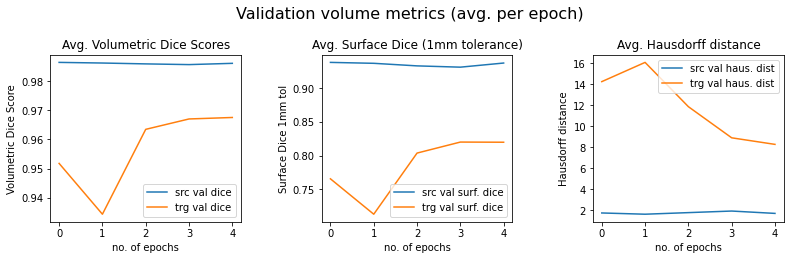

In [ ]:

path = base_path + folder

start_epoch = 0
end_epoch = no_of_epochs
# cplot_train_losses(train_stats,start_epoch, end_epoch, path)
# cplot_train_acc(train_stats, start_epoch, end_epoch, path)

start_epoch = 0
end_epoch = no_of_epochs
# cplot_val_losses(src_val_stats, trg_val_stats, start_epoch, end_epoch, path)
# cplot_val_acc(src_val_stats, trg_val_stats, start_epoch, end_epoch, path)
cplot_volumetric_val(src_val_stats, trg_val_stats, start_epoch, end_epoch, path)